# Time Split Validation - Adversarial EDA - Microsoft Malware
Is anyone else frustrated with the discrepency between CV and LB?! In this kernel, I show an example of two models that both have CV 0.730 but one has LB 0.670 while the other has LB 0.680. Why?! We will explore this and suggest ideas to more accurately estimate LB.

# The Culprit

The Microsoft Malware data has 82 explanatory variables which can all be intrepreted as categorical variables. The reason for CV and LB gap is the difference between TRAIN and TEST variable value distributions. In this kernel, we compare the variable distributions between TRAIN and TEST. If TRAIN and TEST were random samples from the same population then their distributions would be nearly identical (since sample size is a massive 8 million). But this is not what we see! 

Why? Because TRAIN is sampled from the population of August September 2018 while TEST is sampled from the different population October November 2018 (shown [here][1]). Furthermore we believe that PUBLIC TEST is October 2018 and PRIVATE TEST is November 2018 (shown [here][2]).  
  
[1]: https://www.kaggle.com/cdeotte/time-series-eda-malware-0-64
[2]: https://www.kaggle.com/rquintino/2-months-train-1-month-public-1-day-private

In [1]:
import numpy as np, pandas as pd, gc, random
import matplotlib.pyplot as plt

def load(x):
    ignore = ['MachineIdentifier']
    if x in ignore: return False
    else: return True

# LOAD TRAIN AND TEST
df_train = pd.read_csv('../input/microsoft-malware-prediction/train.csv',dtype='category',usecols=load)
df_train['HasDetections'] = df_train['HasDetections'].astype('int8')
if 5244810 in df_train.index:
    df_train.loc[5244810,'AvSigVersion'] = '1.273.1144.0'
    df_train['AvSigVersion'].cat.remove_categories('1.2&#x17;3.1144.0',inplace=True)
#df_train = df_train.sample(8000000).reset_index(drop=True)

df_test = pd.read_csv('../input/microsoft-malware-prediction/test.csv',dtype='category',usecols=load)
#df_test = df_test.sample(1000000).reset_index(drop=True)

# Test Full versus Train Full
To compare the distributions of TEST.csv and TRAIN.csv, I wrote a special Python function. (If interested, click the button 'see code' to view.) The visual may be confusing at first, so let me explain. Basically the plot is two histograms on top of each other. Instead of using bars, it uses a line which follows where the tops of the bars would be. The x-axis are the category variable's possible values. They have been ordered from most frequent in TRAIN to less frequent in TRAIN. Then values containing less than 0.1% of data are removed. Then they are relabeled 0, 1, 2, ... n.

The solid blue line is TRAIN and the solid green line is TEST. If the distributions are the same then the blue and green line would coincide. The dotted blue lines indicate 4x more than TRAIN and 4x less than TRAIN. Therefore if the green line crosses outside the dotted lines, then TEST has a value that is 4x more or 4x less than TRAIN. Let's plot `CountryIdentifier` for TRAIN.csv versus TEST.csv. 

In [2]:
# COMPARE VALUE DENSITIES FROM TWO DIFFERENT DATAFRAMES
#
# PARAMETERS
# df1: pandas.DataFrame containing variable
# df2: pandas.DataFrame containing variable
# col: column to compare between df1 and df2
# override: set to False to prevent display when variables similar
# verbose: display text summary
# scale: zooms y-axis
# title: plot title
# lab1: legend label for df1
# lab2: legend label for df2
# prefix: pre text for verbose summary
#
def comparePlot(df1, df2, col, factor=4, override=True, verbose=True, scale=0.5, title='',
                lab1='', lab2='', prefix=''):
    cv1 = pd.DataFrame(df1[col].value_counts(normalize=True).reset_index().rename({col:'train'},axis=1))
    cv2 = pd.DataFrame(df2[col].value_counts(normalize=True).reset_index().rename({col:'test'},axis=1))
    cv3 = pd.merge(cv1,cv2,on='index',how='outer')
    cv3['train'].fillna(0,inplace=True)
    cv3['test'].fillna(0,inplace=True)
    cv3 = cv3.iloc[np.lexsort((cv3['test'], -cv3['train']))]
    cv3['total'] = cv3['train']+cv3['test']
    cv3['trainMX'] = cv3['train']*factor
    cv3['trainMN'] = cv3['train']/factor
    cv3 = cv3[cv3['total']>0.0001]
    if (len(cv3)<5): return
    cv3.reset_index(inplace=True)
    MX = (cv3['test'] > cv3['trainMX'])
    mxSum = round(100*cv3.loc[MX,'test'].sum(),1)
    MN = (cv3['test'] < cv3['trainMN'])
    mnSum = round(100*cv3.loc[MN,'test'].sum(),1)
    #if override | (MX.sum()+MN.sum()>0):
    if override | (mxSum + mnSum > 1):
        plt.figure(figsize=(15,5))
        if lab1=='': lab1='Train'
        if lab2=='': lab2='Test'
        plt.plot(cv3.index,cv3['train'],linewidth=3,alpha=0.7,color='b',label=lab1)
        plt.plot(cv3.index,cv3['trainMX'],linewidth=2,alpha=1.0,linestyle=':',color='b',label=str())
        plt.plot(cv3.index,cv3['trainMN'],linewidth=2,alpha=1.0,linestyle=':',color='b',label=str())
        #plt.bar(cv3.index,cv3['test'],linewidth=3,alpha=0.7,color='g', label='Test.csv')
        plt.plot(cv3.index,cv3['test'],linewidth=3,alpha=0.7,color='g',label=lab2)
        plt.legend()
        if title=='': plt.title(col)
        else: plt.title(col+' - '+title)
        plt.xlabel(col+' values (ordered by train frequency and relabeled)')
        plt.ylabel('Frequency')
        mx = max(cv3['train'].max(),cv3['test'].max())
        #plt.ylim(0,mx*1.05)
        plt.ylim(0,mx*scale)
        plt.show()
        tempMX = cv3.loc[MX.values,['index','test']].sort_values('test',ascending=False)['index']
        tempMN = cv3.loc[MN.values,['index','test']].sort_values('test',ascending=False)['index']
        if verbose:
            if MX.sum()>0:    
                print(prefix+'Test.csv',col,'has',MX.sum(),'values 4x MORE freq than Train.csv. (',mxSum,'% of data)')
            if MX.sum()>10: print('  Top 10 by test freq:',list(tempMX)[:10])
            elif MX.sum()>0: print(list(tempMX)[:10])
            if MN.sum()>0:
                print(prefix+'Test.csv',col,'has',MN.sum(),'values 4x LESS freq than Train.csv. (',mnSum,'% of data)')
            if MN.sum()>10: print('  Top 10 by test freq:',list(tempMN)[:10])
            elif MN.sum()>0: print(list(tempMN)[:10])
    return

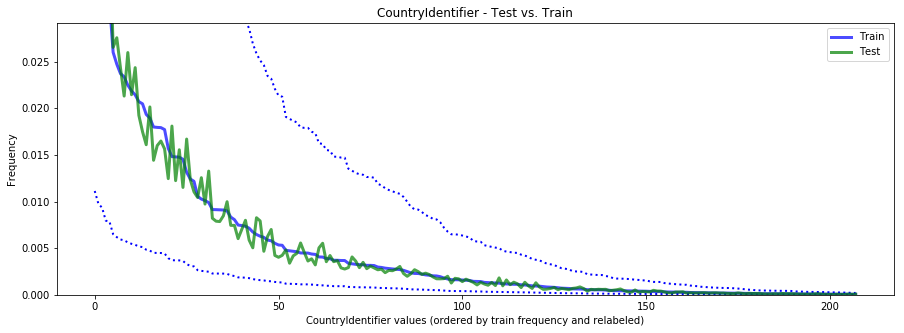

In [3]:
comparePlot(df_train, df_test, 'CountryIdentifier', verbose=False, title='Test vs. Train')

Notice how the green line wiggles and does not stay on top of the blue line. Also notice that it stays within the dotted blue lines. This means that the distribution of `CountryIdentifier` values in TEST.csv are different but pretty similar to TRAIN.csv. It is concerning that they differ. For comparsion, see below. 
# Random Validation Set versus Train Subset
Below I split TRAIN.csv into a randomly selected validation set and training subset. Notice how the distributions are nearly identical. This is what random samples from the same population look like.

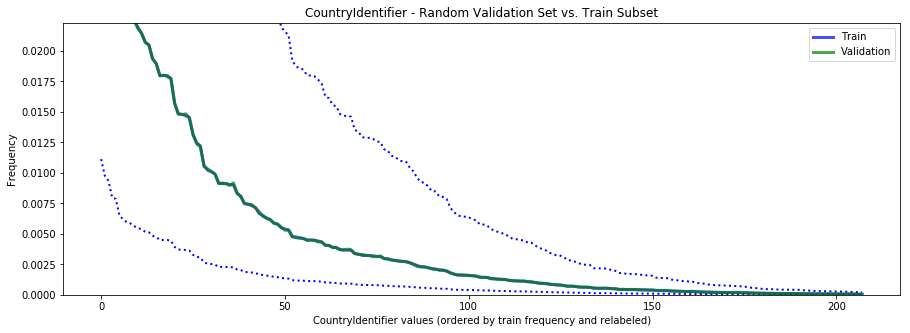

In [4]:
df_trainA = df_train.sample(frac=0.5)
df_trainB = df_train[ ~df_train.index.isin(df_trainA.index)]
comparePlot(df_trainA, df_trainB, 'CountryIdentifier', verbose=False,
            title='Random Validation Set vs. Train Subset', lab1='Train', lab2='Validation')

Comparing the two plots above, we see that a random validation set does not mimic the relationship between TRAIN and TEST. Therefore it is not a good validation scheme to predict LB score.
# Time Split Validation Set versus Train Subset
To make a more useful validation set, lets split TRAIN roughly in half ordered by time using `AvSigVerion` (which is a proxy for time). Then we will compare this Time Split Validation set versus Train subset. All `AvSigVersion` with second number `<275` are before August 23, 2018 while `>=275` are after. This splits TRAIN roughly in half and avoids `AvSigVersion` overlap in the second number (which mimics TEST / TRAIN). We notice that this plot looks more like the TEST TRAIN plot above.

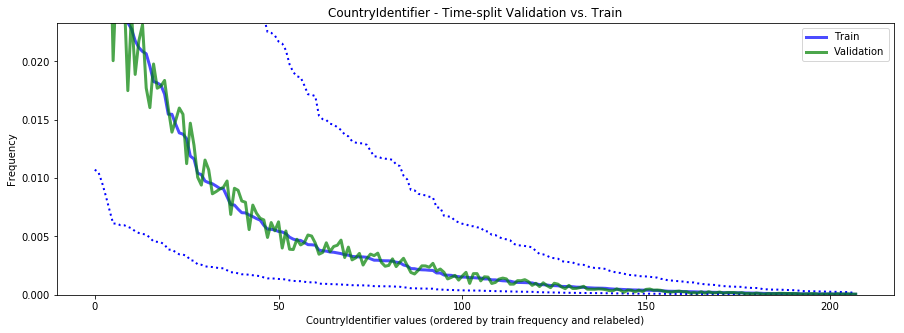

In [5]:
df_train['AvSigVersion2'] = df_train['AvSigVersion'].map(lambda x: np.int(x.split('.')[1]))
df_trainC = df_train[ df_train['AvSigVersion2']<275 ]
df_trainD = df_train[ df_train['AvSigVersion2']>=275 ]
comparePlot(df_trainC, df_trainD, 'CountryIdentifier', verbose=False,
            title='Time-split Validation vs. Train', lab1='Train', lab2='Validation')

# Private Test versus Train Full
The biggest difference in distribution is going from TRAIN to PRIVATE TEST. It is believed that PRIVATE TEST is the month of November 2018. And TRAIN's most recent observation is September 2018. In that large time gap, the distribution of variables will change. Specially it is believed that PRIVATE TEST is after October 25, 2018. Below is the plot of PRIVATE TEST versus TRAIN, and afterward is the plot of PUBLIC TEST versus TRAIN.

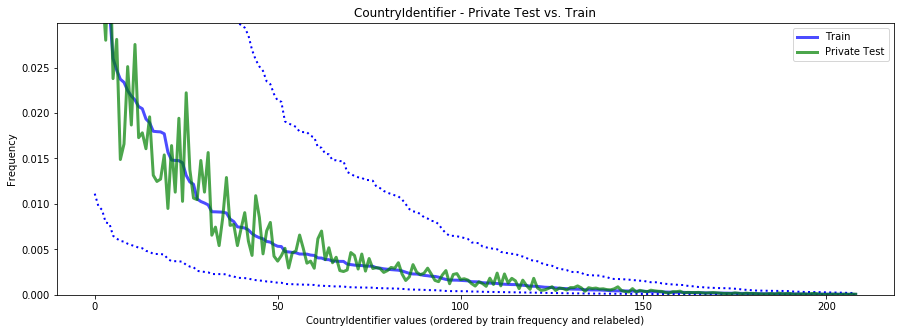

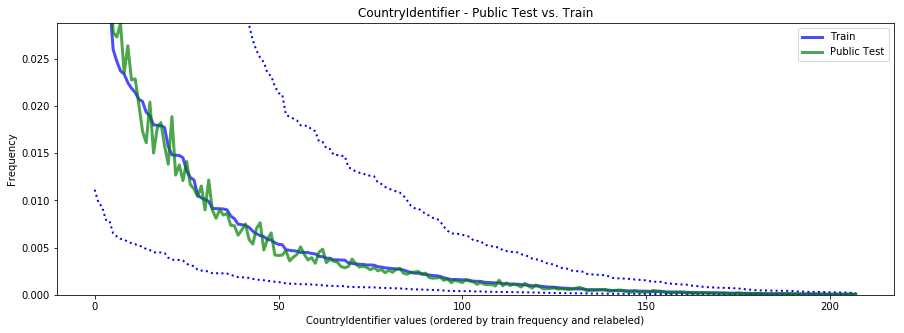

In [6]:
from datetime import datetime
datedictAS = np.load('../input/malware-timestamps/AvSigVersionTimestamps.npy')[()]
df_train['DateAS'] = df_train['AvSigVersion'].map(datedictAS)
df_test['DateAS'] = df_test['AvSigVersion'].map(datedictAS)

df_testA = df_test[ df_test['DateAS']<datetime(2018,10,25) ]
df_testB = df_test[ df_test['DateAS']>datetime(2018,10,25) ]
comparePlot(df_train, df_testB, 'CountryIdentifier', verbose=False,
           title='Private Test vs. Train', lab1='Train', lab2='Private Test')
comparePlot(df_train, df_testA, 'CountryIdentifier', verbose=False,
           title='Public Test vs. Train', lab1='Train', lab2='Public Test')

# LB Score versus CV Score
We now understand how the distribution of TEST differs from TRAIN. Let's now compare a Time Split Validation scheme to a Random Validation scheme. Let's see which one more accurately estimates LB. In order to compare, we will need two sets of variables (two models). 

## Model One
Our first set of variables will be the entire TRAIN.csv converted into categories with no further processing.
## Model Two
Our second set of variables will be the entire TRAIN.csv with certain values removed. Notice I say values not variables. For each of the 82 variables, we will look at all their possible values in TRAIN. If a value does not appear in TEST, we will remove it. If a value appears less than 0.01% of total TRAIN, we will remove it. If a value appears 4x more frequent in TRAIN than TEST, we will remove it. If a value appears 4x less frequent in TRAIN than TEST, we will remove it. (This idea is from [Vladislav Bogorod's][2] brillant kernel [here][1].)

For example, the variable `AppVersion` contains the value `4.18.1807.18075`. This value appears in TRAIN over 4x as frequent as it appears in TEST. Therefore we will remove this value's category from `AppVersion`. All values that appear 4x more or 4x less are indicated in the compare plots whenever the green solid line crosses over the blue dotted line in. (Note: It has been shown that model two can score 0.692 LB [here][1])

## Result
Below we will see that  
  
    Model One scores: 0.732 Random, 0.695 TimeSplit, 0.672 LB  
    Model Two scores: 0.729 Random, 0.704 TimeSplit, 0.681 LB

This shows that Time Split Validation was better able to estimate LB score than Random Validation (typical CV). It's a relief to find a test that distinguishes models with different LB scores!
  
[1]: https://www.kaggle.com/bogorodvo/upd-lightgbm-baseline-model-using-sparse-matrix
[2]: https://www.kaggle.com/bogorodvo

In [7]:
# FACTORIZE DATA
def factor_data(df_train, df_test, col):
    df_comb = pd.concat([df_train[col],df_test[col]],axis=0)
    df_comb,_ = df_comb.factorize(sort=True)
    # MAKE SMALLEST LABEL 1, RESERVE 0
    df_comb += 1
    # MAKE NAN LARGEST LABEL
    df_comb = np.where(df_comb==0, df_comb.max()+1, df_comb)
    df_train[col] = df_comb[:len(df_train)]
    df_test[col] = df_comb[len(df_train):]
    del df_comb
    
# OPTIMIZE MEMORY
def reduce_memory(df,col):
    mx = df[col].max()
    if mx<256:
            df[col] = df[col].astype('uint8')
    elif mx<65536:
        df[col] = df[col].astype('uint16')
    else:
        df[col] = df[col].astype('uint32')

# REDUCE CATEGORY CARDINALITY
def relax_data(df_train, df_test, col):
    cv1 = pd.DataFrame(df_train[col].value_counts().reset_index().rename({col:'train'},axis=1))
    cv2 = pd.DataFrame(df_test[col].value_counts().reset_index().rename({col:'test'},axis=1))
    cv3 = pd.merge(cv1,cv2,on='index',how='outer')
    cv3['train'].fillna(0,inplace=True)
    cv3['test'].fillna(0,inplace=True)
    factor = len(df_test)/len(df_train)
    cv3['remove'] = False
    cv3['remove'] = cv3['remove'] | (cv3['train'] < len(df_train)/9000)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] < cv3['test']/4)
    cv3['remove'] = cv3['remove'] | (factor*cv3['train'] > 4*cv3['test'])
    cv3['new'] = cv3.apply(lambda x: x['index'] if x['remove']==False else 0,axis=1)
    cv3['new'],_ = cv3['new'].factorize(sort=True)
    cv3.set_index('index',inplace=True)
    cc = cv3['new'].to_dict()
    df_train[col] = df_train[col].map(cc)
    reduce_memory(df_train,col)
    df_test[col] = df_test[col].map(cc)
    reduce_memory(df_test,col)
    
# DISPLAY MEMORY STATISTICS
def display_memory(df_train, df_test):
    print(len(df_train),'rows of training data use',df_train.memory_usage(deep=True).sum()//1e6,'Mb memory!')
    print(len(df_test),'rows of test data use',df_test.memory_usage(deep=True).sum()//1e6,'Mb memory!')

# CONVERT DTYPES TO CATEGORIES
def categorize(df_train, df_test, cols):
    for col in cols:
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

In [8]:
del df_trainA, df_trainB, df_trainC, df_trainD
del df_train['DateAS'], df_test['DateAS']; x=gc.collect()
cols = [x for x in df_train.columns if x not in ['HasDetections','AvSigVersion2']]
    
print('Factorizing...')
for col in cols: factor_data(df_train, df_test, col)
print('Reducing memory...')
for col in cols: reduce_memory(df_train, col)
for col in cols: reduce_memory(df_test, col)
categorize(df_train, df_test, cols)
display_memory(df_train, df_test)

Factorizing...
Reducing memory...
8921483 rows of training data use 1161.0 Mb memory!
7853253 rows of test data use 954.0 Mb memory!


# Model One: using Random Validation

In [9]:
import lightgbm as lgb
df_trainA = df_train.sample(frac=0.5)
df_trainB = df_train[ ~df_train.index.isin(df_trainA.index)]
model = lgb.LGBMClassifier(n_estimators=3000, colsample_bytree=0.2, objective='binary', num_leaves=16,
          max_depth=-1, learning_rate=0.1)
h=model.fit(df_trainA[cols], df_trainA['HasDetections'], eval_metric='auc',
          eval_set=[(df_trainB[cols], df_trainB['HasDetections'])], verbose=250,
          early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.721838	valid_0's binary_logloss: 0.609795
[500]	valid_0's auc: 0.725	valid_0's binary_logloss: 0.60704
[750]	valid_0's auc: 0.726485	valid_0's binary_logloss: 0.605857
[1000]	valid_0's auc: 0.727554	valid_0's binary_logloss: 0.605052
[1250]	valid_0's auc: 0.728474	valid_0's binary_logloss: 0.604295
[1500]	valid_0's auc: 0.729139	valid_0's binary_logloss: 0.603778
[1750]	valid_0's auc: 0.729615	valid_0's binary_logloss: 0.603394
[2000]	valid_0's auc: 0.730001	valid_0's binary_logloss: 0.603078
[2250]	valid_0's auc: 0.73047	valid_0's binary_logloss: 0.602726
[2500]	valid_0's auc: 0.730862	valid_0's binary_logloss: 0.602393
[2750]	valid_0's auc: 0.731136	valid_0's binary_logloss: 0.602179
[3000]	valid_0's auc: 0.731478	valid_0's binary_logloss: 0.601919
Did not meet early stopping. Best iteration is:
[2994]	valid_0's auc: 0.731482	valid_0's binary_logloss: 0.601917


In [10]:
del df_trainA, df_trainB; x=gc.collect()
idx = 0; chunk = 2000000
pred_val = np.zeros(len(df_test))
while idx < len(df_test):
    idx2 = min(idx + chunk, len(df_test) )
    idx = range(idx, idx2)
    pred_val[idx] = model.predict_proba(df_test.iloc[idx][cols])[:,1]
    idx = idx2
submit = pd.read_csv('../input/microsoft-malware-prediction/sample_submission.csv')
submit['HasDetections'] = pred_val
submit.to_csv('ModelOne.csv', index=False)

![image](http://playagricola.com/Kaggle/one21319.png)

# Model One: using Time Split Validation

In [11]:
df_trainC = df_train[ df_train['AvSigVersion2']<275 ]
df_trainD = df_train[ df_train['AvSigVersion2']>=275 ]
model = lgb.LGBMClassifier(n_estimators=3000, colsample_bytree=0.2, objective='binary', num_leaves=16,
          max_depth=-1, learning_rate=0.1)
h=model.fit(df_trainC[cols], df_trainC['HasDetections'], eval_metric='auc',
          eval_set=[(df_trainD[cols], df_trainD['HasDetections'])], verbose=250,
          early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.693006	valid_0's binary_logloss: 0.631445
[500]	valid_0's auc: 0.69445	valid_0's binary_logloss: 0.629628
Early stopping, best iteration is:
[443]	valid_0's auc: 0.695342	valid_0's binary_logloss: 0.6297


# Model Two: using Time Split Validation

In [12]:
print('Converting data to Model Two...')
df_trainC = df_trainC.copy()
df_trainD = df_trainD.copy()
for col in cols: relax_data(df_trainC, df_trainD, col)
categorize(df_trainC, df_trainD, cols)
model = lgb.LGBMClassifier(n_estimators=3000, colsample_bytree=0.2, objective='binary', num_leaves=16,
          max_depth=-1, learning_rate=0.1)
h=model.fit(df_trainC[cols], df_trainC['HasDetections'], eval_metric='auc',
          eval_set=[(df_trainD[cols], df_trainD['HasDetections'])], verbose=250,
          early_stopping_rounds=100)

Converting data to Model Two...
Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.695435	valid_0's binary_logloss: 0.631766
[500]	valid_0's auc: 0.699155	valid_0's binary_logloss: 0.629161
[750]	valid_0's auc: 0.70029	valid_0's binary_logloss: 0.628427
[1000]	valid_0's auc: 0.701171	valid_0's binary_logloss: 0.62781
[1250]	valid_0's auc: 0.701982	valid_0's binary_logloss: 0.627329
[1500]	valid_0's auc: 0.702573	valid_0's binary_logloss: 0.626927
[1750]	valid_0's auc: 0.703	valid_0's binary_logloss: 0.626672
Early stopping, best iteration is:
[1883]	valid_0's auc: 0.70322	valid_0's binary_logloss: 0.626536


# Model Two: using Random Validation

In [13]:
print('Converting data to Model Two...')
del df_trainC, df_trainD; x=gc.collect()
for col in cols: relax_data(df_train, df_test, col)
categorize(df_train, df_test, cols)
df_trainA = df_train.sample(frac=0.5)
df_trainB = df_train[ ~df_train.index.isin(df_trainA.index)]
model = lgb.LGBMClassifier(n_estimators=3000, colsample_bytree=0.2, objective='binary', num_leaves=16,
          max_depth=-1, learning_rate=0.1)
h=model.fit(df_trainA[cols], df_trainA['HasDetections'], eval_metric='auc',
          eval_set=[(df_trainB[cols], df_trainB['HasDetections'])], verbose=250,
          early_stopping_rounds=100)

Converting data to Model Two...
Training until validation scores don't improve for 100 rounds.
[250]	valid_0's auc: 0.719793	valid_0's binary_logloss: 0.611792
[500]	valid_0's auc: 0.723029	valid_0's binary_logloss: 0.609145
[750]	valid_0's auc: 0.724566	valid_0's binary_logloss: 0.607966
[1000]	valid_0's auc: 0.725475	valid_0's binary_logloss: 0.607249
[1250]	valid_0's auc: 0.726211	valid_0's binary_logloss: 0.606666
[1500]	valid_0's auc: 0.726924	valid_0's binary_logloss: 0.606097
[1750]	valid_0's auc: 0.727372	valid_0's binary_logloss: 0.605727
[2000]	valid_0's auc: 0.727701	valid_0's binary_logloss: 0.605467
[2250]	valid_0's auc: 0.728006	valid_0's binary_logloss: 0.605226
[2500]	valid_0's auc: 0.728263	valid_0's binary_logloss: 0.605022
[2750]	valid_0's auc: 0.728478	valid_0's binary_logloss: 0.604856
[3000]	valid_0's auc: 0.728652	valid_0's binary_logloss: 0.60471
Did not meet early stopping. Best iteration is:
[2995]	valid_0's auc: 0.728654	valid_0's binary_logloss: 0.604708


In [14]:
del df_trainA, df_trainB, df_train; x=gc.collect()
idx = 0; chunk = 2000000
pred_val = np.zeros(len(df_test))
while idx < len(df_test):
    idx2 = min(idx + chunk, len(df_test) )
    idx = range(idx, idx2)
    pred_val[idx] = model.predict_proba(df_test.iloc[idx][cols])[:,1]
    idx = idx2
submit = pd.read_csv('../input/microsoft-malware-prediction/sample_submission.csv')
submit['HasDetections'] = pred_val
submit.to_csv('ModelTwo.csv', index=False)

![image](http://playagricola.com/Kaggle/two21319.png)

# Conclusion
In conclusion, we see how a time split validation scheme approximates LB better than a random validation scheme. Additionally, using compare plots EDA helps us choose time stable variables for our models. Below I show an alternative method, adversarial validation. After that I present all the compare plots.

# Adversarial Validation
Alternatively, some people use adversarial validation to discover troublesome values and/or test their models. Above, we used Compare Plots to discover troublesome values and then created our Model One and Model Two. We won't use adversarial validation here to find variables, but we will apply adversarial validation on Model One and Model Two to confirm that we did a good job. (Note since I use a small tree below, I use training AUC to approximate validation AUC.)
## What is Adversarial Validation?
Normallly a model classifies which computers have Malware and which computers do not. In adversarial validation, we mix all the TRAIN and TEST data together. We add a new variable `IsTest`. For all computers from TEST, we set `IsTest=1` and all computers from TRAIN, we set `IsTest=0`. We then build a model that attempts to classify whether a computer is `IsTest` or not. If the distribution of variables are the same in TEST and TRAIN (were randomly drawn from the sample population), then an adversarial model can not distinguish TEST from TRAIN. But when the distributions are different, it can. Below we witness how an adversarial model can distinquish TEST from TRAIN when using the variables from Model One but cannot distinguish when using the variables from Model Two. (With the exception that I need to remove `SMode` since it is skewed but didn't exceed 4x.)

Model One: Adversarial Training AUC =  0.955
Adversarial Model has max_leaf_nodes=5


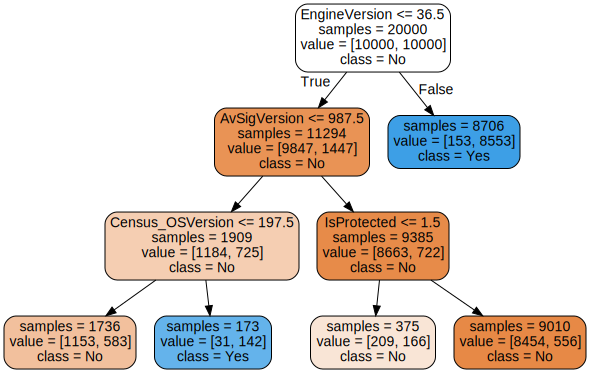

In [15]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score
from sklearn import tree
import graphviz

# LOAD TRAIN AND TEST
df_train = pd.read_csv('../input/microsoft-malware-prediction/train.csv',dtype='category',usecols=load, nrows=10000)
df_train['HasDetections'] = df_train['HasDetections'].astype('int8')
if 5244810 in df_train.index:
    df_train.loc[5244810,'AvSigVersion'] = '1.273.1144.0'
    df_train['AvSigVersion'].cat.remove_categories('1.2&#x17;3.1144.0',inplace=True)
#df_train = df_train.sample(1000000).reset_index(drop=True)
df_test = pd.read_csv('../input/microsoft-malware-prediction/test.csv',dtype='category',usecols=load, nrows=10000)
#df_test = df_test.sample(1000000).reset_index(drop=True)

# FACTORIZE
cols = [x for x in df_train.columns if x not in ['HasDetections','AvSigVersion2']]
for col in cols: factor_data(df_train, df_test, col)
for col in cols: reduce_memory(df_train, col)
for col in cols: reduce_memory(df_test, col)
categorize(df_train, df_test, cols)
# COMBINE TRAIN AND TEST
df_train['HasDetections'] = 0
df_test['HasDetections'] = 1
df_comb = pd.concat([df_train,df_test],axis=0)

# VALIDATION
model = DecisionTreeClassifier(max_leaf_nodes=5)
model.fit(df_comb[cols], df_comb['HasDetections'])
pred_val = model.predict_proba(df_comb[cols])[:,1]
print('Model One: Adversarial Training AUC = ',round( roc_auc_score(df_comb['HasDetections'],pred_val),4 ) )
#print('Adversarial Model has tree depth =',model.tree_.max_depth,'and node count =',model.tree_.node_count)
print('Adversarial Model has max_leaf_nodes=5')
# PLOT TREE                    
tree_graph = tree.export_graphviz(model, out_file=None, max_depth = 10,
        impurity = False, feature_names = cols, class_names = ['No', 'Yes'],
        rounded = True, filled= True )
graphviz.Source(tree_graph)

Model Two: Adversarial Training AUC =  0.6136
Adversarial Model has max_leaf_nodes=5


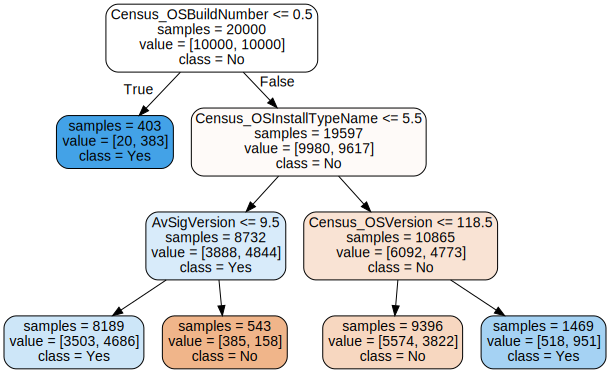

In [16]:
# CONVERT VARIABLES TO MODEL TWO
for col in cols: relax_data(df_train, df_test, col)
categorize(df_train, df_test, cols)
df_comb = pd.concat([df_train,df_test],axis=0)
# REMOVE TROUBLESOME SMODE
cols2 = cols.copy()
cols2.remove('SMode')

#VALIDATION
model = DecisionTreeClassifier(max_leaf_nodes=5)
model.fit(df_comb[cols2], df_comb['HasDetections'])
pred_val = model.predict_proba(df_comb[cols2])[:,1]
print('Model Two: Adversarial Training AUC = ',round( roc_auc_score(df_comb['HasDetections'],pred_val),4 ) )
#print('Adversarial Model has tree depth =',model.tree_.max_depth,'and node count =',model.tree_.node_count)
print('Adversarial Model has max_leaf_nodes=5')
# PLOT TREE          
tree_graph = tree.export_graphviz(model, out_file=None, max_depth = 10,
        impurity = False, feature_names = cols2, class_names = ['No', 'Yes'],
        rounded = True, filled= True )
graphviz.Source(tree_graph)

# EDA Compare Plots
Below are all variables containing 5 or more categories (after removing values with less than 0.1% overall data). The most troublesome variables are: `EngineVersion`, `AvSigVersion`, `AppVersion`, `Census_OSVersion`, `Census_OSBuildRevision`, `DefaultBrowsersIdentifier`, `OsBuildLab`, `IeVerIdentifier`, `OsBuild`, `OsPlatformSubRelease`, `Census_OSBranch`, `Census_OSBuildNumber`. These variables have 89%, 84%, 70%, 38%, 37%, 9%, 7%, 3%, 2%, 2%, 2%, 2% differences between TRAIN and PUBLIC TEST respectively. And 100%, 100%, 84%, 60%, 60%, 11%, 12%, 6%, 6%, 6%, 6%, 6% differences between TRAIN and PRIVATE TEST. 
  
In order to make the most accurate model, you need to do something with these variables.  Recall that Model Two above was created by removing all values from these variables where the green solid line crosses the blue dotted line. To create a better model, transform these values into new values, whose TEST TRAIN distribution is similar. Use creative feature engineering and/or encoding techniques.

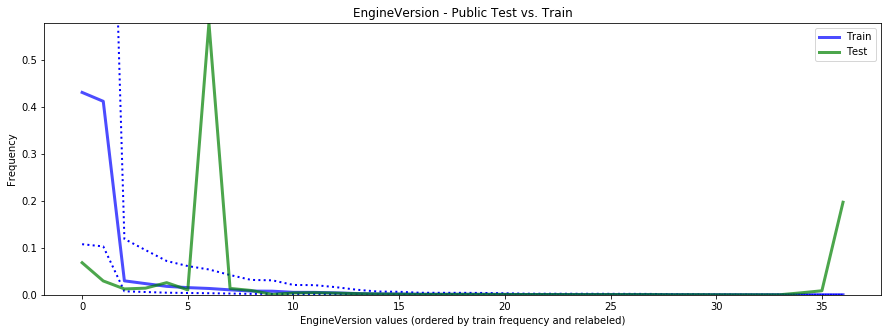

Public Test.csv EngineVersion has 4 values 4x MORE freq than Train.csv. ( 78.9 % of data)
['1.1.15300.6', '1.1.15400.4', '1.1.15400.5', '1.1.15400.3']
Public Test.csv EngineVersion has 3 values 4x LESS freq than Train.csv. ( 9.9 % of data)
['1.1.15200.1', '1.1.15100.1', '1.1.15300.5']


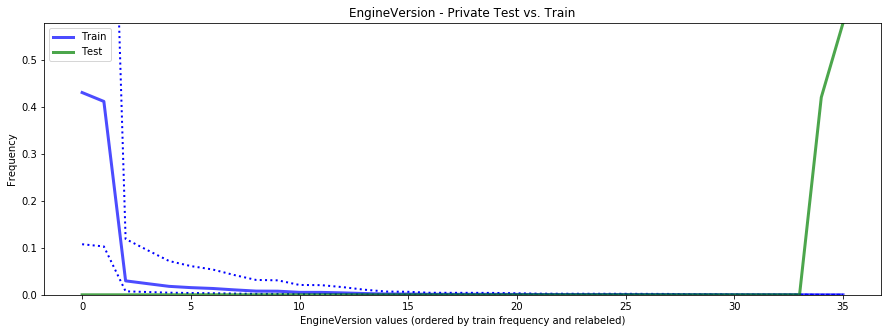

Private Test.csv EngineVersion has 2 values 4x MORE freq than Train.csv. ( 100.0 % of data)
['1.1.15400.5', '1.1.15400.4']
Private Test.csv EngineVersion has 34 values 4x LESS freq than Train.csv. ( 0.0 % of data)
  Top 10 by test freq: ['1.1.15300.6', '1.1.15200.1', '1.1.13103.0', '1.1.13601.0', '1.1.12902.0', '1.1.14305.0', '1.1.13701.0', '1.1.13704.0', '1.1.13202.0', '1.1.13000.0']


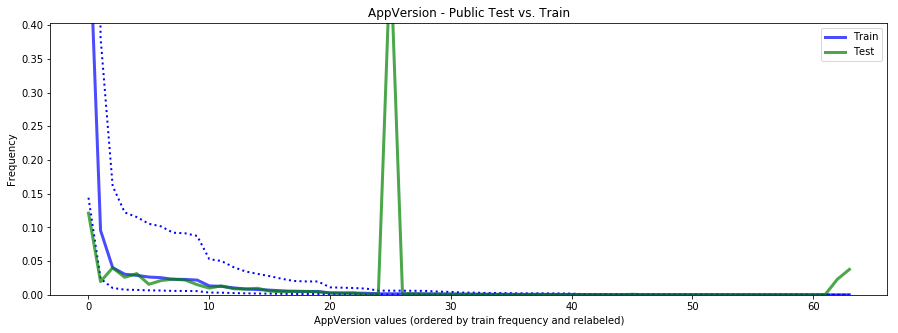

Public Test.csv AppVersion has 5 values 4x MORE freq than Train.csv. ( 56.6 % of data)
['4.18.1809.2', '4.18.1810.5', '4.13.17134.320', '4.13.17134.319', '4.18.1809.20006']
Public Test.csv AppVersion has 3 values 4x LESS freq than Train.csv. ( 14.1 % of data)
['4.18.1807.18075', '4.18.1806.18062', '4.8.10240.17914']


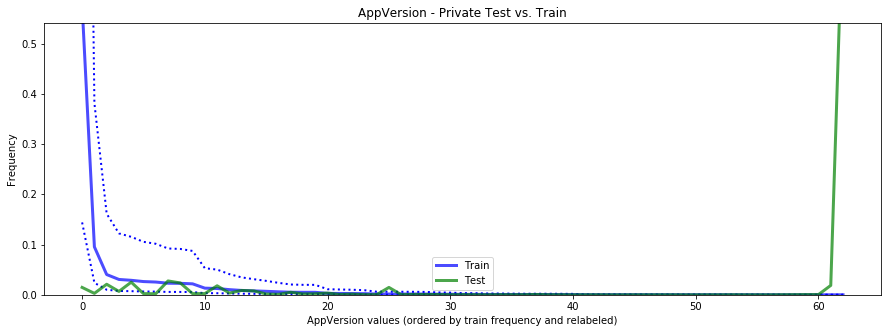

Private Test.csv AppVersion has 7 values 4x MORE freq than Train.csv. ( 80.7 % of data)
['4.18.1810.5', '4.13.17134.320', '4.18.1809.2', '4.8.10240.18036', '4.18.1810.20029', '4.18.1810.20017', '4.18.1810.20021']
Private Test.csv AppVersion has 20 values 4x LESS freq than Train.csv. ( 3.8 % of data)
  Top 10 by test freq: ['4.18.1807.18075', '4.10.209.0', '4.18.1806.18062', '4.12.17007.18022', '4.16.17656.18052', '4.14.17639.18041', '4.13.17134.228', '4.12.17007.18011', '4.14.17613.18039', '4.10.14393.1198']


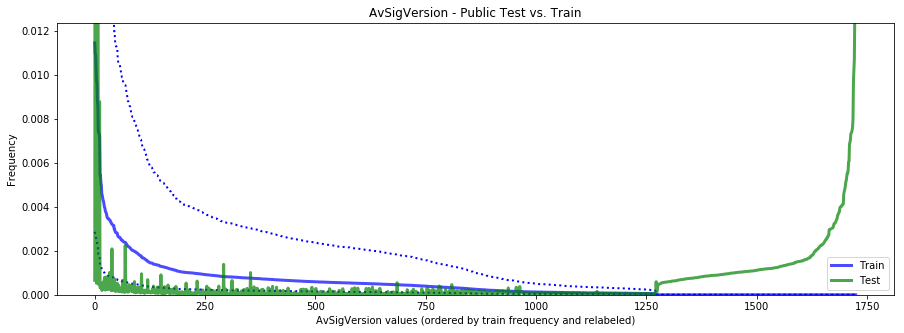

Public Test.csv AvSigVersion has 453 values 4x MORE freq than Train.csv. ( 76.6 % of data)
  Top 10 by test freq: ['1.277.515.0', '1.279.102.0', '1.279.32.0', '1.277.96.0', '1.277.1044.0', '1.277.1102.0', '1.277.1050.0', '1.277.950.0', '1.277.881.0', '1.277.871.0']
Public Test.csv AvSigVersion has 756 values 4x LESS freq than Train.csv. ( 7.4 % of data)
  Top 10 by test freq: ['1.275.1244.0', '1.275.1140.0', '1.275.727.0', '1.275.1209.0', '1.275.1487.0', '1.275.1293.0', '1.275.1458.0', '1.273.1826.0', '1.273.1420.0', '1.275.1025.0']


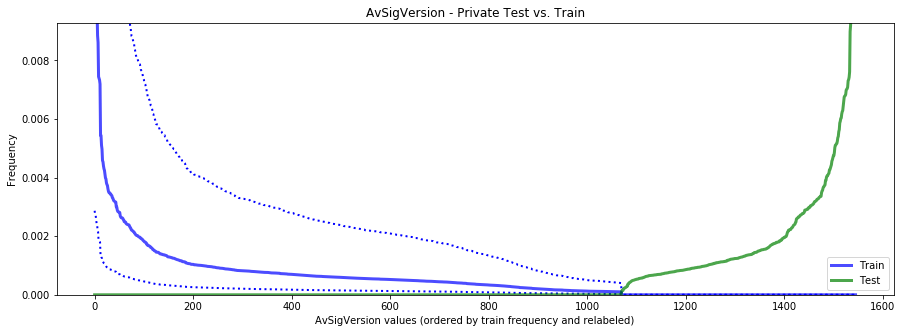

Private Test.csv AvSigVersion has 476 values 4x MORE freq than Train.csv. ( 100.0 % of data)
  Top 10 by test freq: ['1.281.261.0', '1.281.739.0', '1.281.308.0', '1.279.1442.0', '1.281.118.0', '1.279.806.0', '1.279.955.0', '1.279.922.0', '1.281.211.0', '1.279.478.0']
Private Test.csv AvSigVersion has 1070 values 4x LESS freq than Train.csv. ( 0.0 % of data)
  Top 10 by test freq: ['1.273.1420.0', '1.275.488.0', '1.273.1176.0', '1.275.396.0', '1.275.398.0', '1.273.1587.0', '1.269.1925.0', '1.275.794.0', '1.273.844.0', '1.273.1241.0']


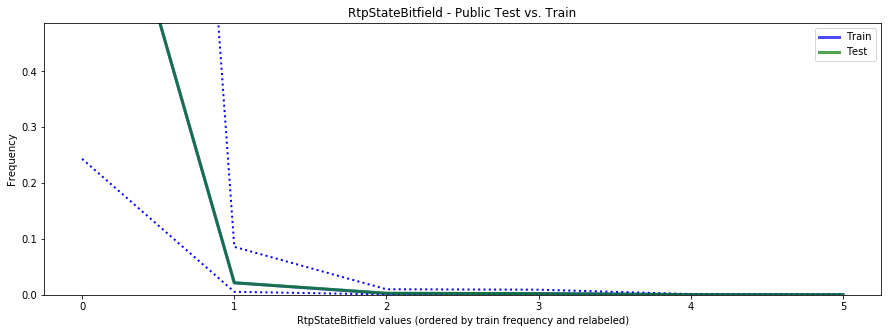

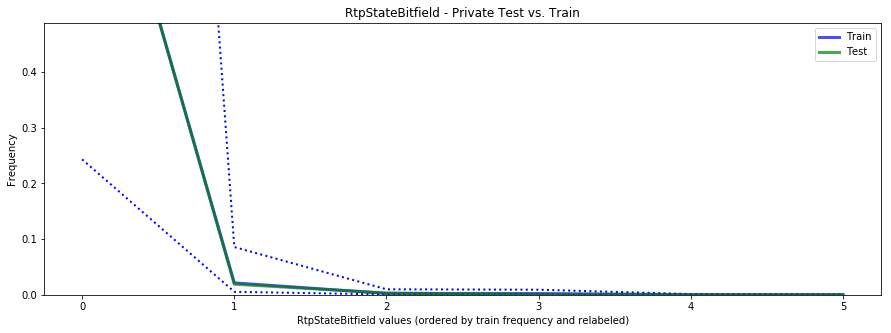

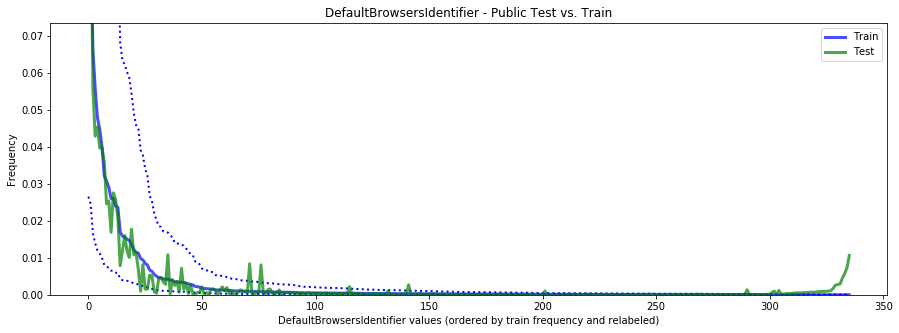

Public Test.csv DefaultBrowsersIdentifier has 43 values 4x MORE freq than Train.csv. ( 8.0 % of data)
  Top 10 by test freq: ['1448', '2603', '431', '2377', '426', '233', '1068', '3038', '1984', '1530']
Public Test.csv DefaultBrowsersIdentifier has 32 values 4x LESS freq than Train.csv. ( 0.9 % of data)
  Top 10 by test freq: ['2434', '1616', '139', '597', '1870', '2182', '168', '645', '2460', '1351']


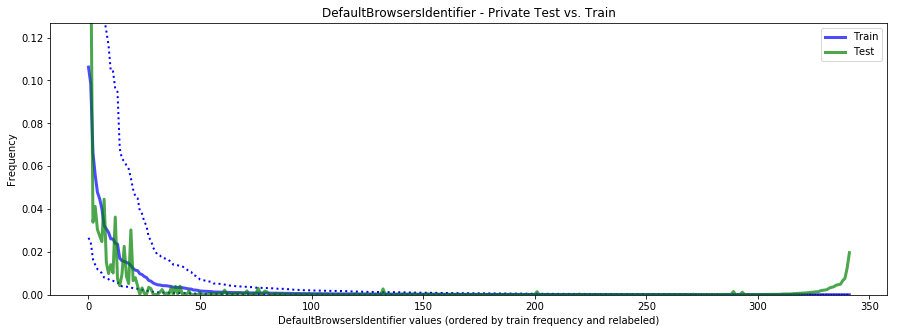

Private Test.csv DefaultBrowsersIdentifier has 60 values 4x MORE freq than Train.csv. ( 10.4 % of data)
  Top 10 by test freq: ['1448', '426', '1530', '3002', '2824', '3038', '2078', '30', '373', '51']
Private Test.csv DefaultBrowsersIdentifier has 68 values 4x LESS freq than Train.csv. ( 0.7 % of data)
  Top 10 by test freq: ['1628', '2189', '1616', '1870', '2987', '311', '2434', '645', '139', '597']


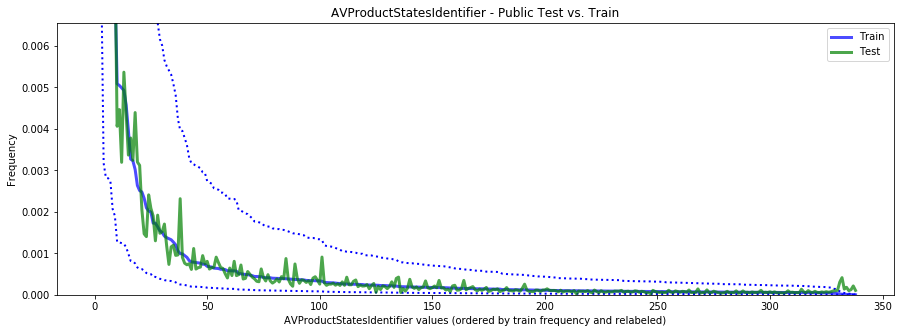

Public Test.csv AVProductStatesIdentifier has 8 values 4x MORE freq than Train.csv. ( 0.2 % of data)
['45439', '6229', '45096', '45345', '6205', '6148', '41110', '45578']


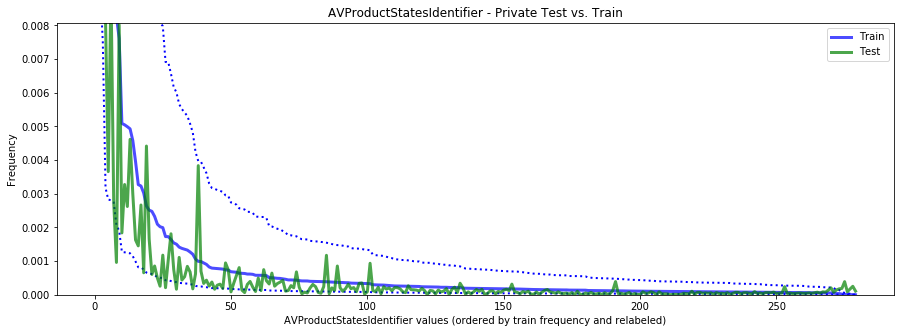

Private Test.csv AVProductStatesIdentifier has 8 values 4x MORE freq than Train.csv. ( 0.2 % of data)
['45439', '45096', '6229', '45553', '45345', '55928', '41412', '6205']
Private Test.csv AVProductStatesIdentifier has 59 values 4x LESS freq than Train.csv. ( 0.5 % of data)
  Top 10 by test freq: ['29199', '61343', '24213', '11280', '61100', '9471', '70262', '42652', '23141', '61859']


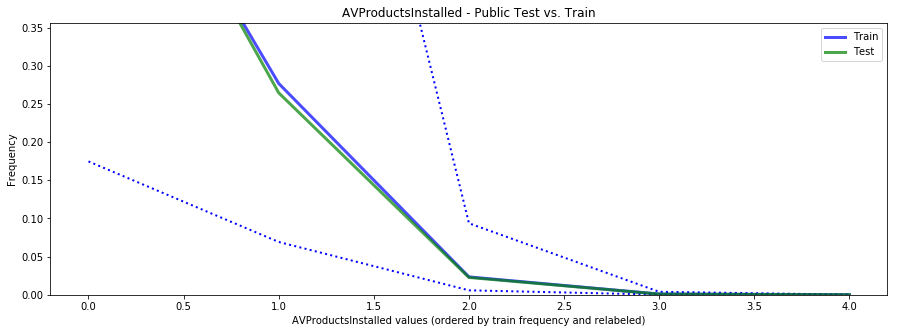

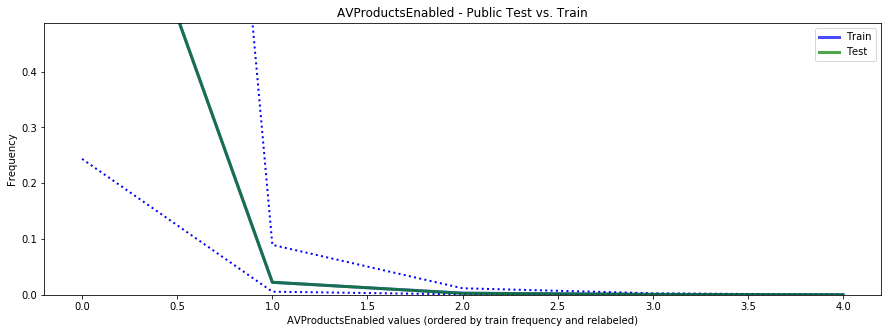

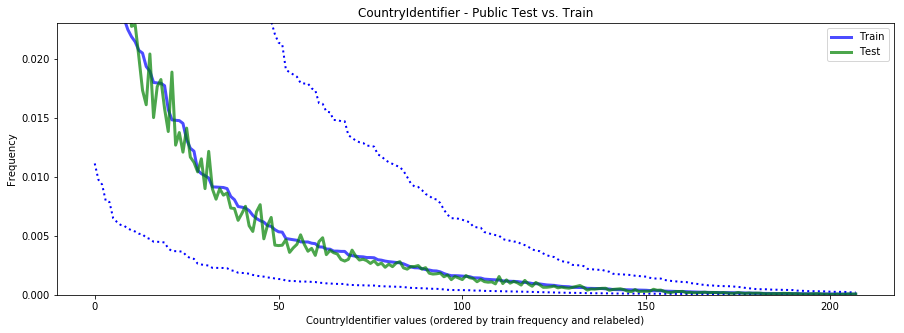

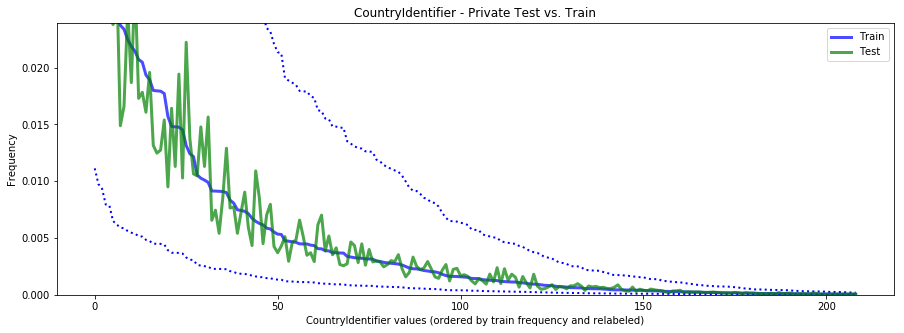

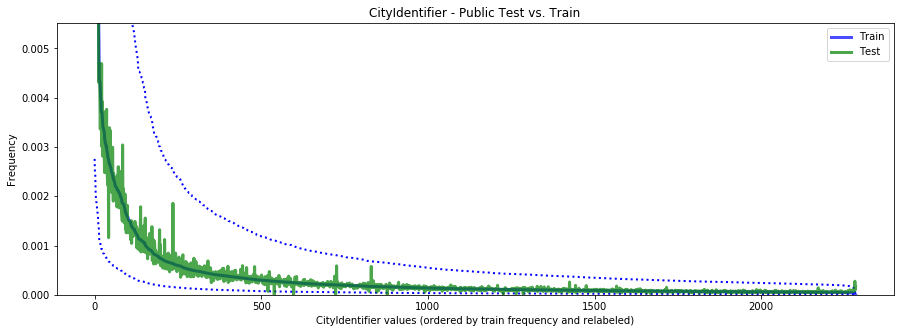

Public Test.csv CityIdentifier has 3 values 4x MORE freq than Train.csv. ( 0.1 % of data)
['70129', '30482', '5041']
Public Test.csv CityIdentifier has 8 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['11879', '131913', '116269', '163010', '131083', '70130', '143466', '155656']


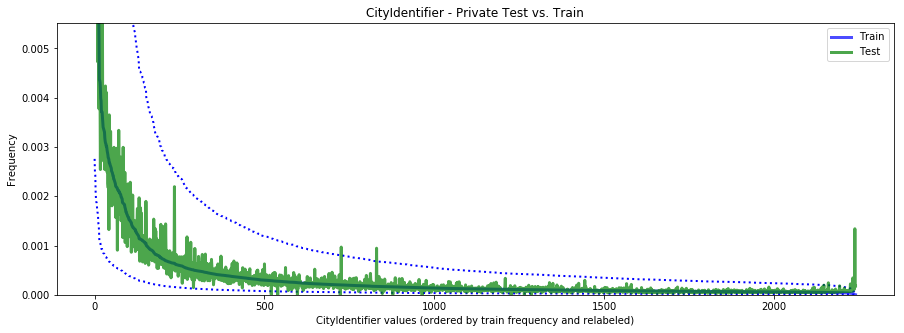

Private Test.csv CityIdentifier has 14 values 4x MORE freq than Train.csv. ( 0.5 % of data)
  Top 10 by test freq: ['30482', '5888', '149657', '70129', '51314', '66674', '113573', '112600', '164901', '50352']
Private Test.csv CityIdentifier has 10 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['155882', '11879', '131083', '131913', '116269', '70130', '148387', '143466', '155656', '163010']


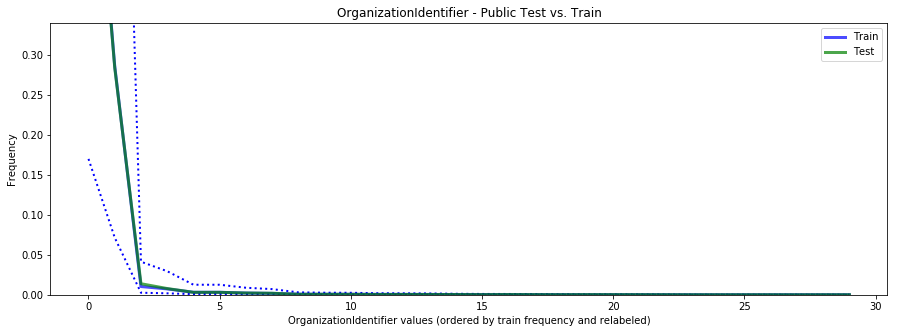

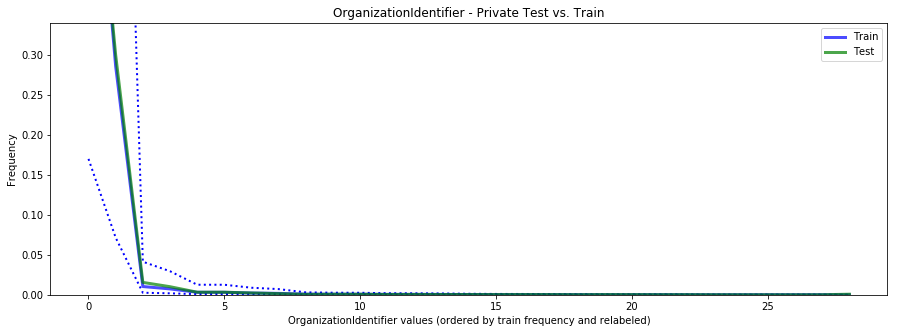

Private Test.csv OrganizationIdentifier has 1 values 4x MORE freq than Train.csv. ( 0.1 % of data)
['38']


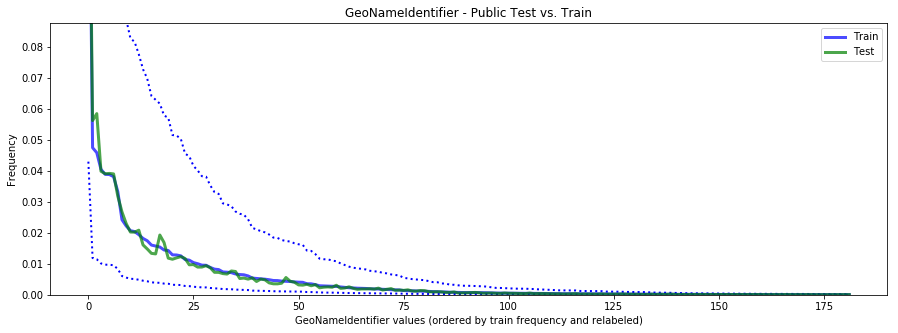

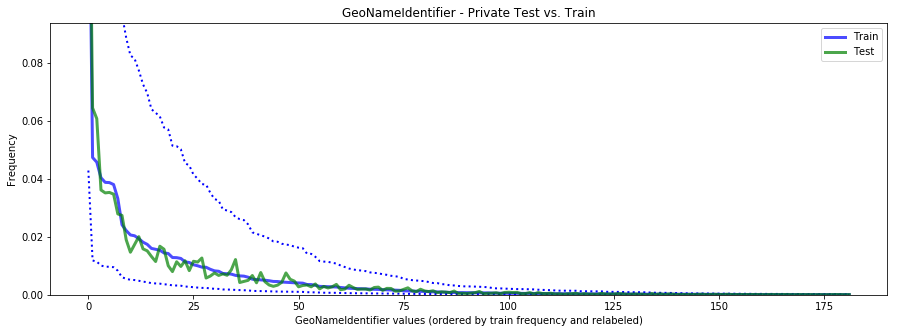

Private Test.csv GeoNameIdentifier has 1 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['286']


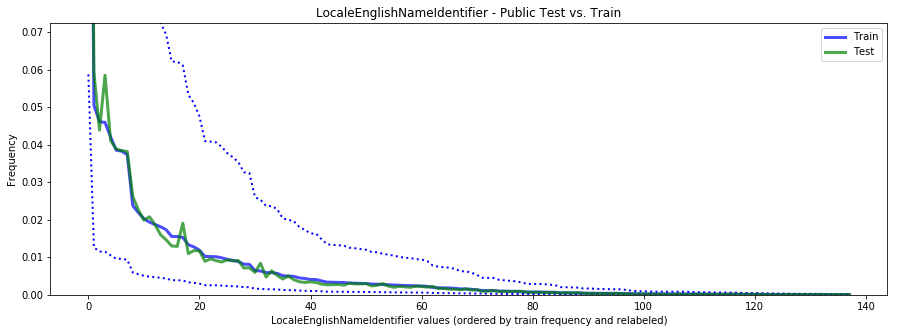

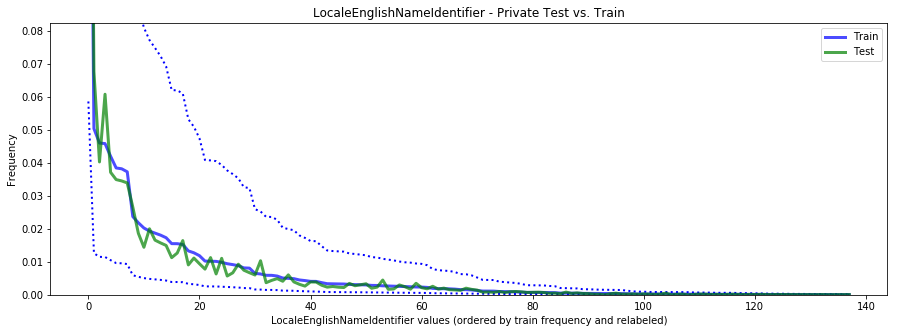

Private Test.csv LocaleEnglishNameIdentifier has 3 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['65', '160', '237']


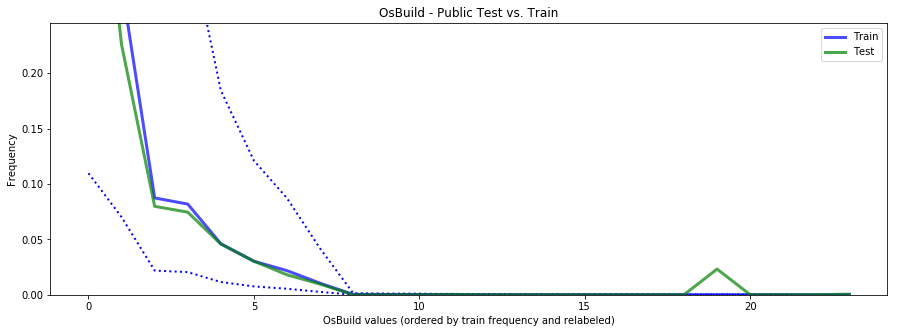

Public Test.csv OsBuild has 3 values 4x MORE freq than Train.csv. ( 2.4 % of data)
['17763', '18252', '18262']
Public Test.csv OsBuild has 6 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['17692', '17738', '17746', '17713', '17741', '17735']


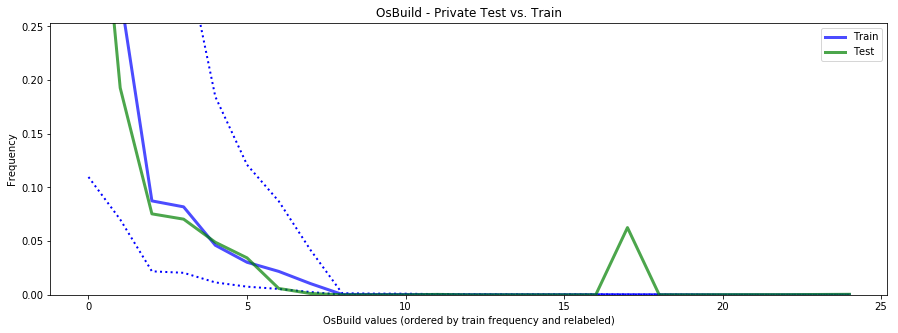

Private Test.csv OsBuild has 6 values 4x MORE freq than Train.csv. ( 6.4 % of data)
['17763', '18282', '18272', '18277', '18267', '18262']
Private Test.csv OsBuild has 9 values 4x LESS freq than Train.csv. ( 0.1 % of data)
['7601', '17744', '17751', '17754', '17692', '17738', '17746', '17713', '17735']


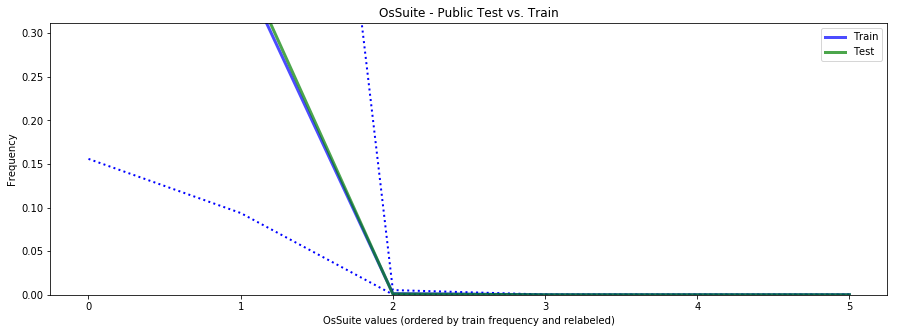

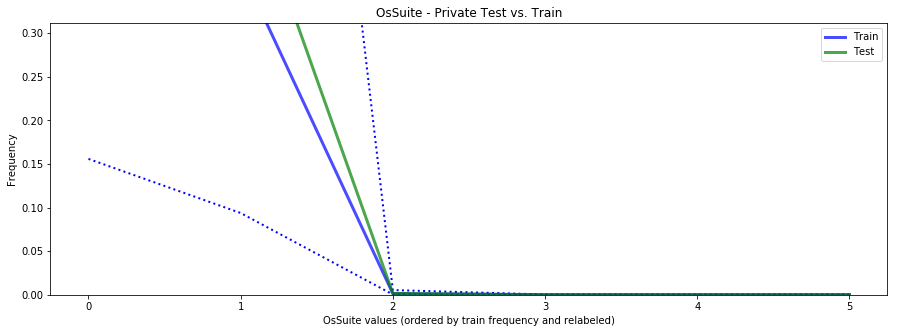

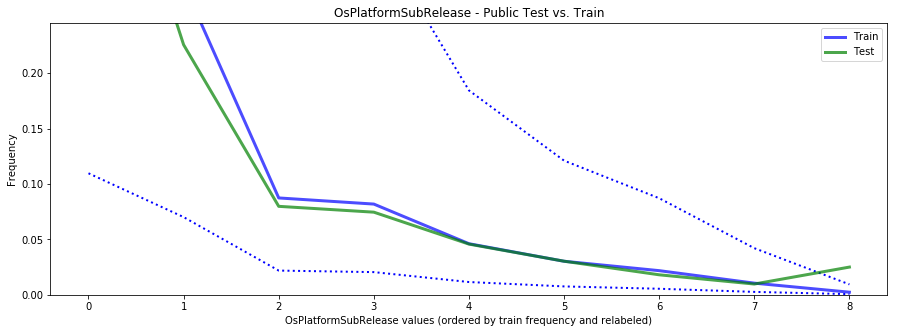

Public Test.csv OsPlatformSubRelease has 1 values 4x MORE freq than Train.csv. ( 2.5 % of data)
['prers5']


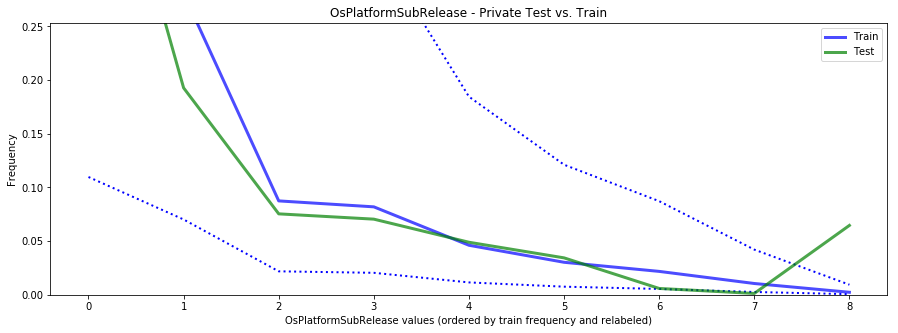

Private Test.csv OsPlatformSubRelease has 1 values 4x MORE freq than Train.csv. ( 6.5 % of data)
['prers5']
Private Test.csv OsPlatformSubRelease has 1 values 4x LESS freq than Train.csv. ( 0.1 % of data)
['windows7']


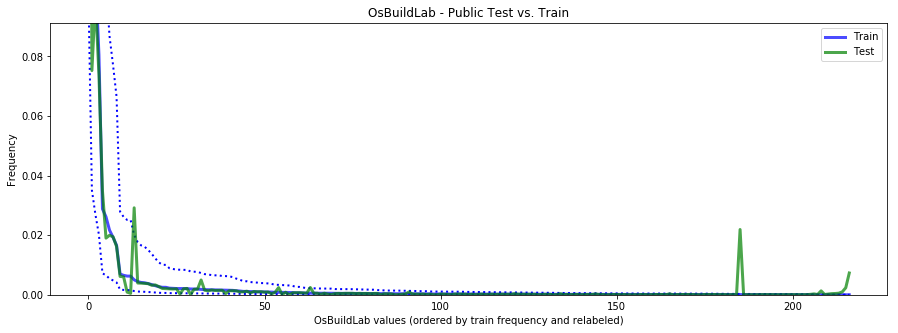

Public Test.csv OsBuildLab has 14 values 4x MORE freq than Train.csv. ( 6.8 % of data)
  Top 10 by test freq: ['16299.637.amd64fre.rs3_release_svc.180808-1748', '17763.1.amd64fre.rs5_release.180914-1434', '9600.19153.amd64fre.winblue_ltsb.180908-0600', '16299.637.x86fre.rs3_release_svc.180808-1748', '7601.24260.amd64fre.win7sp1_ldr.180908-0600', '17763.1.x86fre.rs5_release.180914-1434', '7601.24260.x86fre.win7sp1_ldr.180908-0600', '18252.1000.amd64fre.rs_prerelease.180928-1410', '9600.19153.x86fre.winblue_ltsb.180908-0600', '14393.2551.amd64fre.rs1_release.181004-1309']
Public Test.csv OsBuildLab has 23 values 4x LESS freq than Train.csv. ( 0.3 % of data)
  Top 10 by test freq: ['9600.19101.amd64fre.winblue_ltsb_escrow.180718-1800', '9600.19067.amd64fre.winblue_ltsb_escrow.180619-2033', '7601.24214.amd64fre.win7sp1_ldr_escrow.180801-1700', '7601.24168.amd64fre.win7sp1_ldr.180608-0600', '7601.24150.amd64fre.win7sp1_ldr_escrow.180528-1700', '7601.24214.x86fre.win7sp1_ldr_escrow.180801-17

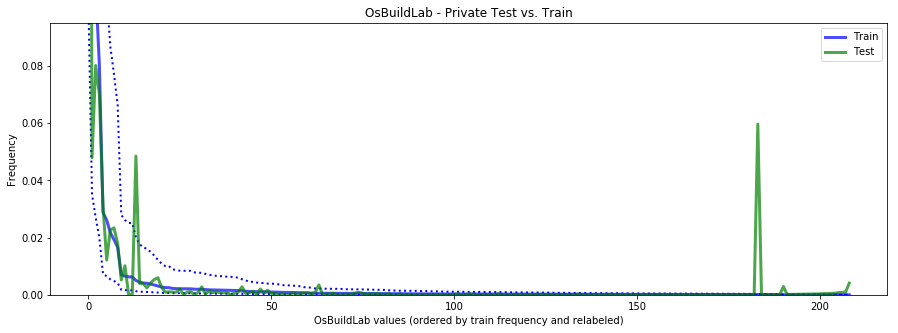

Private Test.csv OsBuildLab has 22 values 4x MORE freq than Train.csv. ( 12.5 % of data)
  Top 10 by test freq: ['17763.1.amd64fre.rs5_release.180914-1434', '16299.637.amd64fre.rs3_release_svc.180808-1748', '9600.19153.amd64fre.winblue_ltsb.180908-0600', '16299.637.x86fre.rs3_release_svc.180808-1748', '17763.1.x86fre.rs5_release.180914-1434', '14393.2608.amd64fre.rs1_release.181024-1742', '9600.19179.amd64fre.winblue_ltsb_escrow.181015-1847', '14393.2551.amd64fre.rs1_release.181004-1309', '10240.18005.amd64fre.th1.180924-1744', '14393.2580.amd64fre.rs1_release_inmarket.181009-1745']
Private Test.csv OsBuildLab has 54 values 4x LESS freq than Train.csv. ( 0.1 % of data)
  Top 10 by test freq: ['9600.19125.amd64fre.winblue_ltsb.180812-0703', '7601.24231.amd64fre.win7sp1_ldr.180810-0600', '9600.18821.amd64fre.winblue_ltsb.170914-0600', '7601.24231.x86fre.win7sp1_ldr.180810-0600', '9600.19101.amd64fre.winblue_ltsb_escrow.180718-1800', '14393.2395.amd64fre.rs1_release_inmarket.180714-1932',

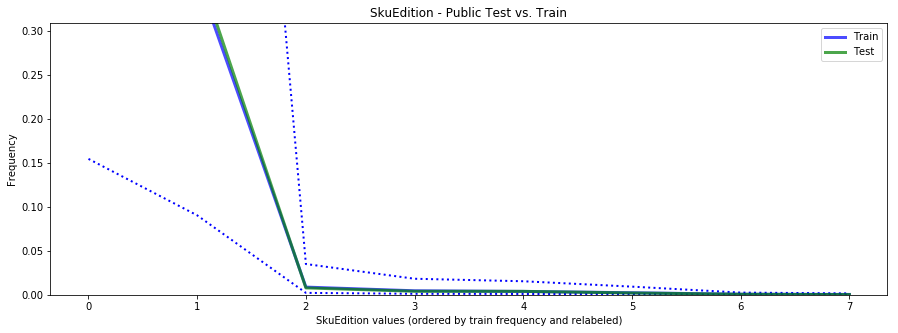

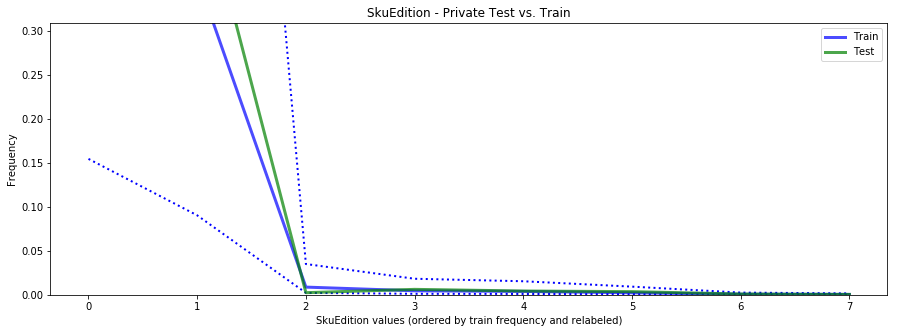

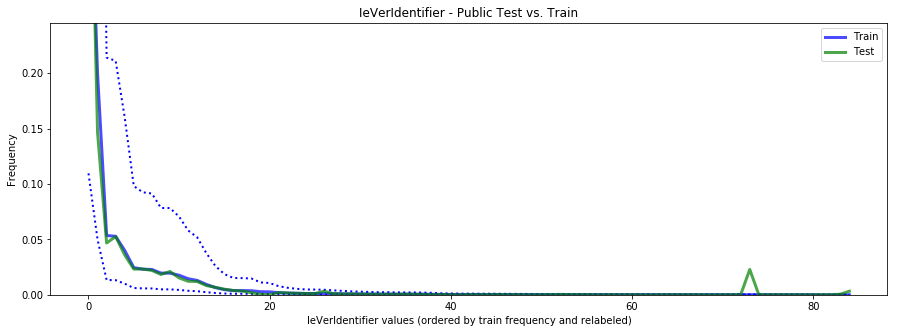

Public Test.csv IeVerIdentifier has 5 values 4x MORE freq than Train.csv. ( 2.7 % of data)
['205', '339', '234', '338', '246']
Public Test.csv IeVerIdentifier has 9 values 4x LESS freq than Train.csv. ( 0.1 % of data)
['335', '334', '163', '180', '186', '169', '182', '65', '178']


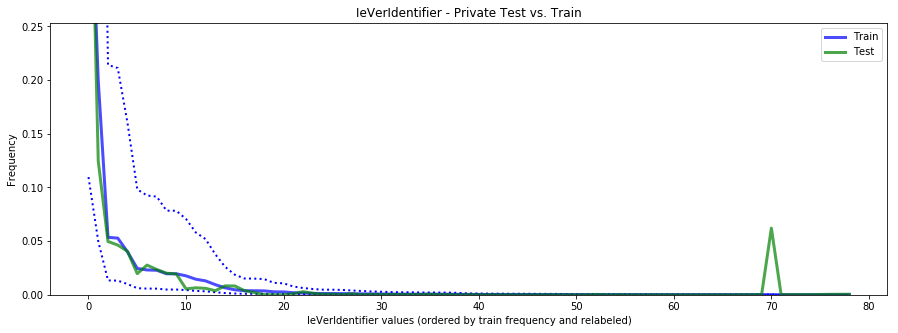

Private Test.csv IeVerIdentifier has 9 values 4x MORE freq than Train.csv. ( 6.4 % of data)
['205', '70', '339', '264', '254', '259', '251', '340', '246']
Private Test.csv IeVerIdentifier has 26 values 4x LESS freq than Train.csv. ( 0.1 % of data)
  Top 10 by test freq: ['323', '337', '302', '295', '185', '190', '194', '335', '307', '64']


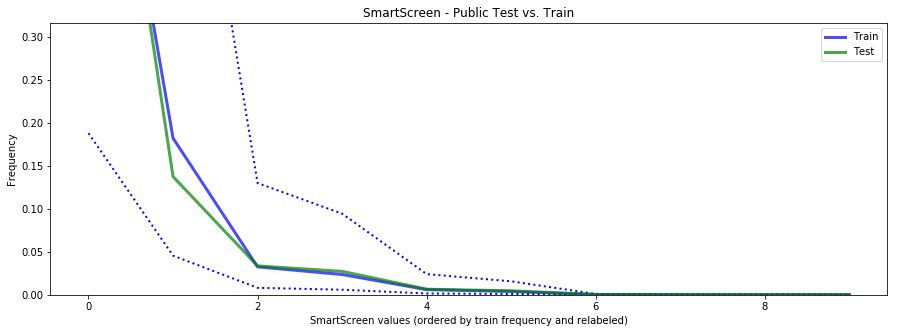

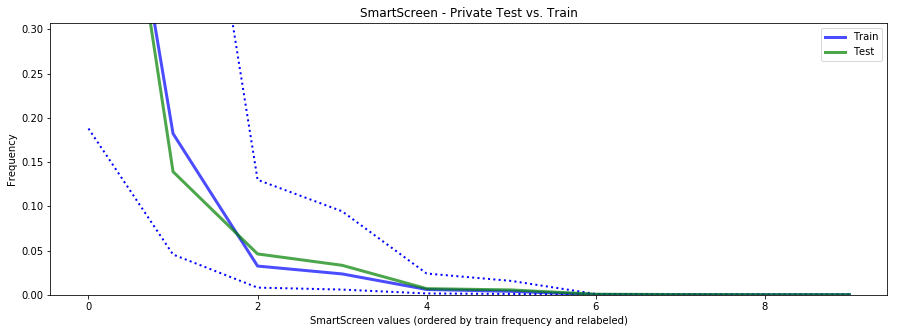

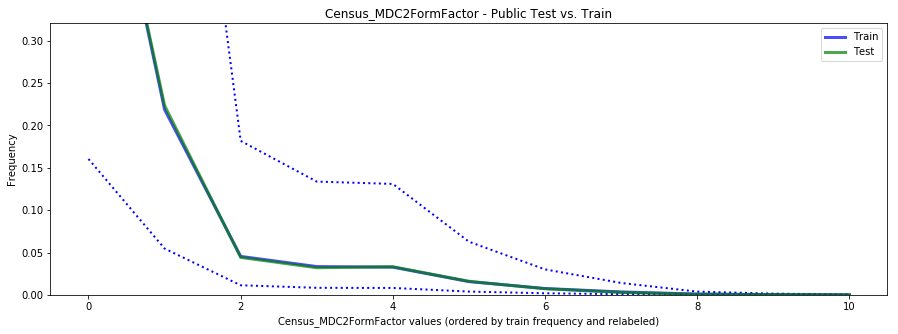

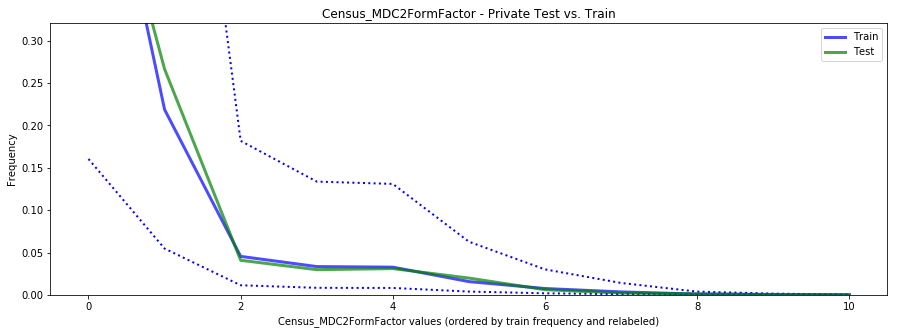

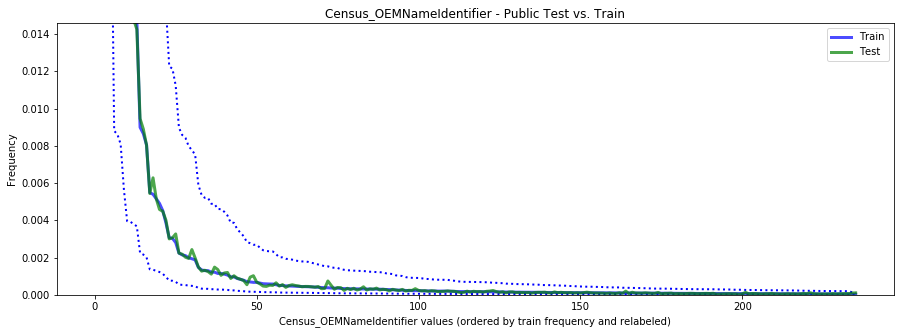

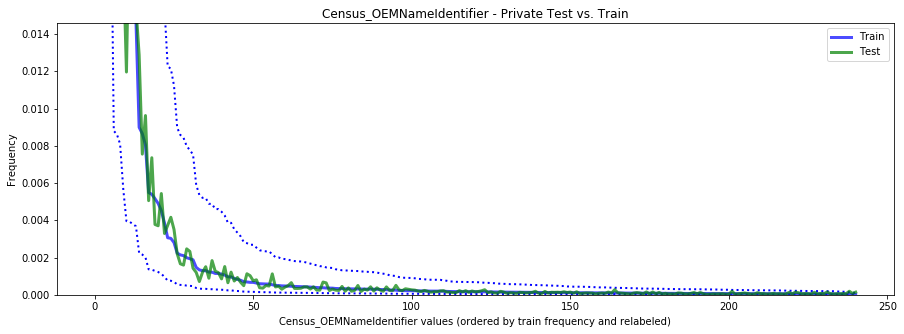

Private Test.csv Census_OEMNameIdentifier has 2 values 4x MORE freq than Train.csv. ( 0.0 % of data)
['2281', '994']


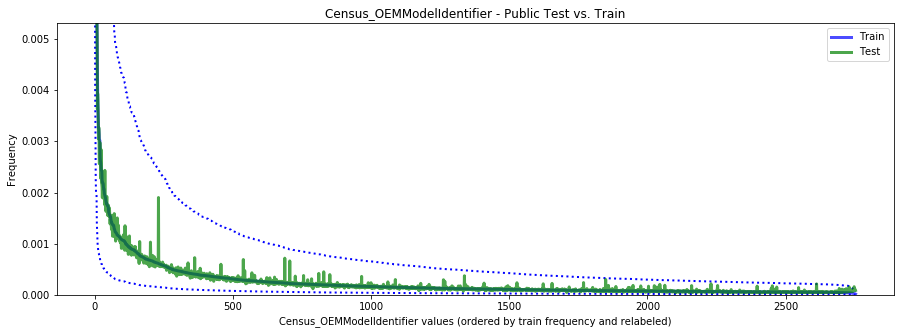

Public Test.csv Census_OEMModelIdentifier has 8 values 4x MORE freq than Train.csv. ( 0.1 % of data)
['328238', '328198', '263775', '328253', '190917', '328255', '172147', '250509']


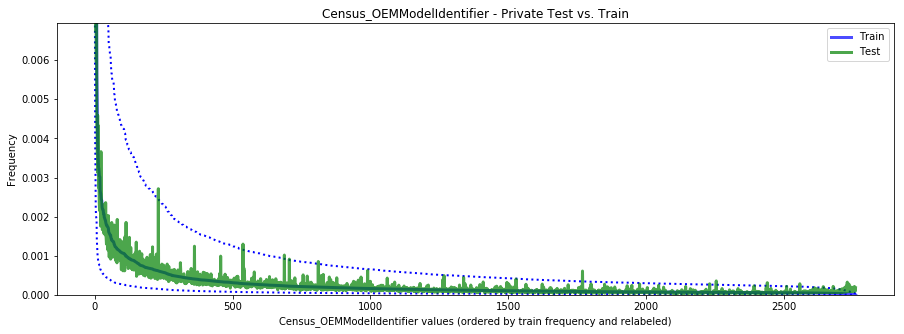

Private Test.csv Census_OEMModelIdentifier has 46 values 4x MORE freq than Train.csv. ( 1.4 % of data)
  Top 10 by test freq: ['241921', '172153', '241818', '241924', '313501', '172144', '172148', '263775', '172179', '328238']


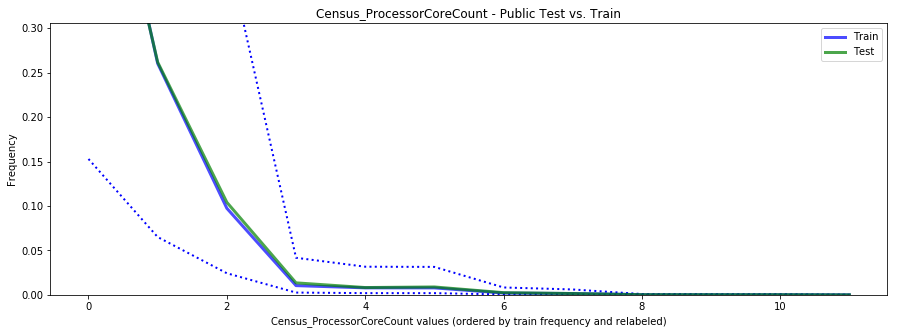

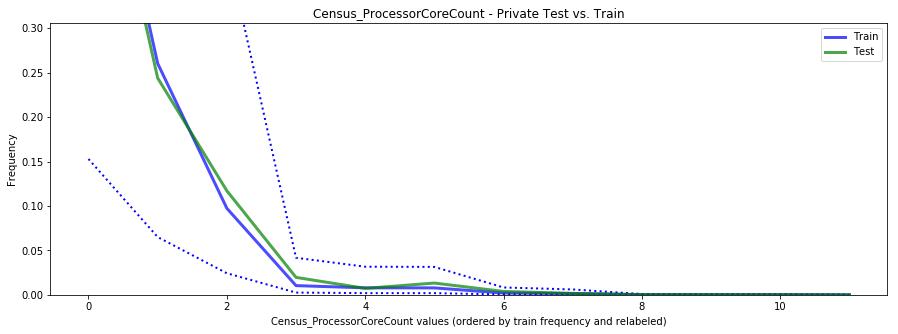

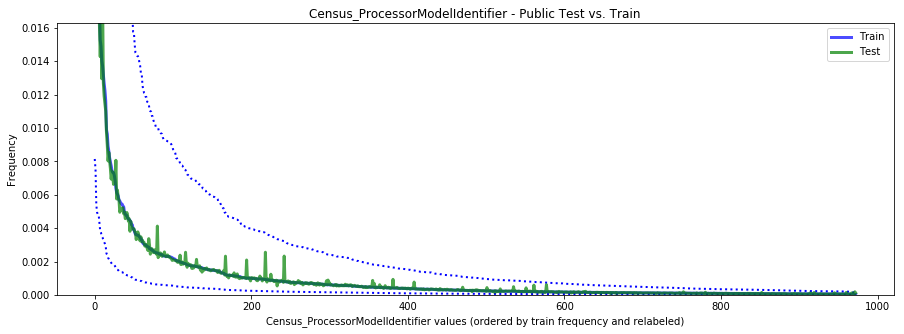

Public Test.csv Census_ProcessorModelIdentifier has 2 values 4x MORE freq than Train.csv. ( 0.0 % of data)
['158', '2744']


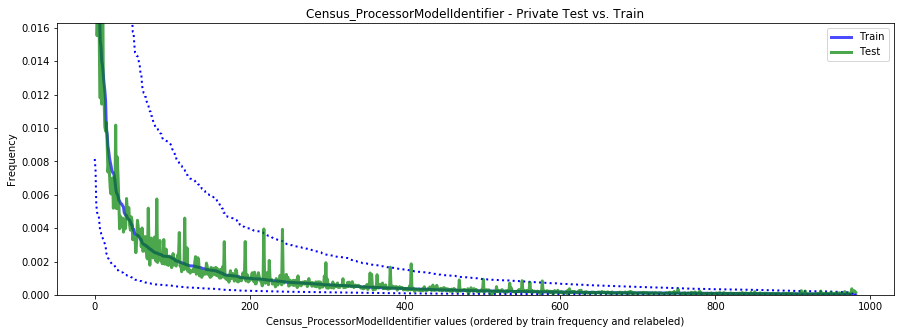

Private Test.csv Census_ProcessorModelIdentifier has 16 values 4x MORE freq than Train.csv. ( 1.5 % of data)
  Top 10 by test freq: ['2133', '2405', '1266', '3550', '3416', '316', '158', '2107', '3141', '2742']
Private Test.csv Census_ProcessorModelIdentifier has 8 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['270', '187', '660', '652', '129', '199', '658', '143']


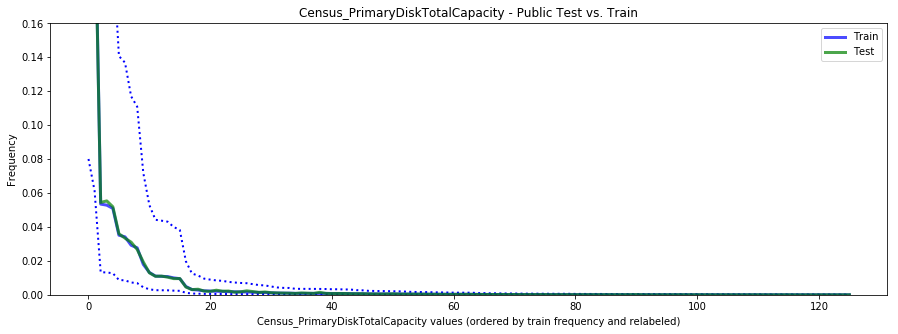

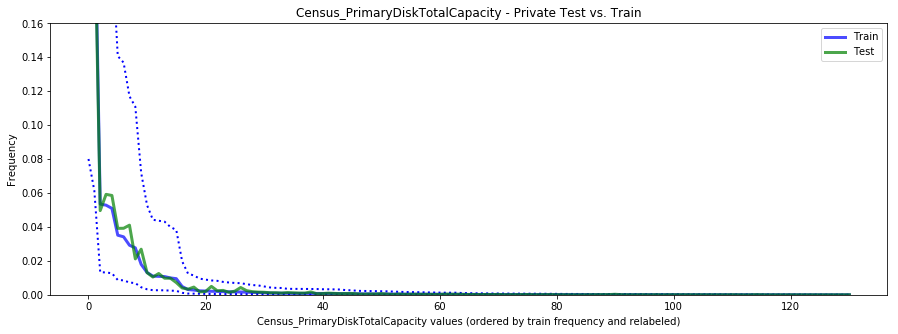

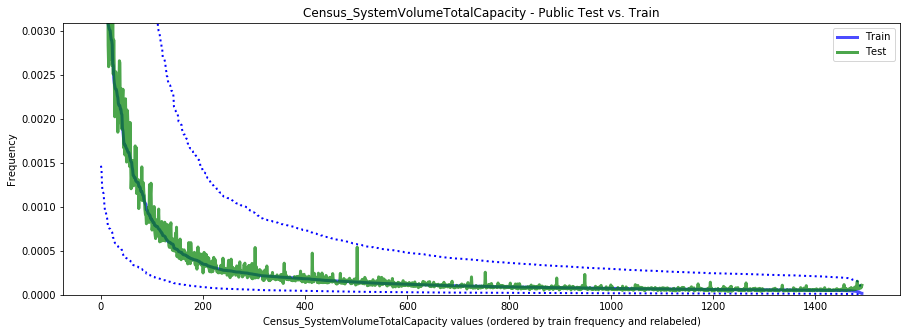

Public Test.csv Census_SystemVolumeTotalCapacity has 4 values 4x MORE freq than Train.csv. ( 0.0 % of data)
['85233', '476958', '935991', '459467']


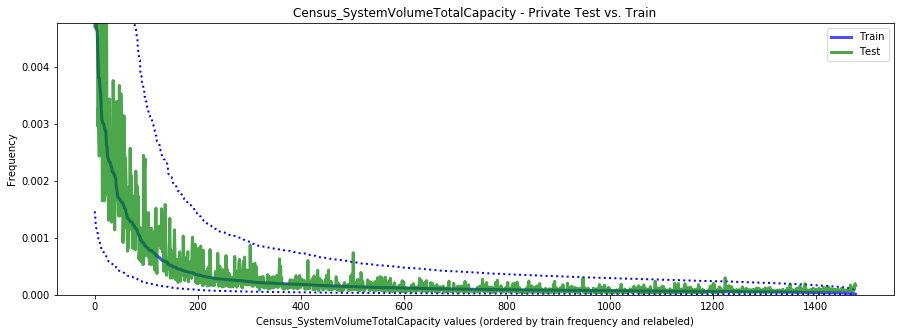

Private Test.csv Census_SystemVolumeTotalCapacity has 9 values 4x MORE freq than Train.csv. ( 0.2 % of data)
['952791', '58226', '476958', '58561', '475011', '121599', '935991', '459467', '28741']


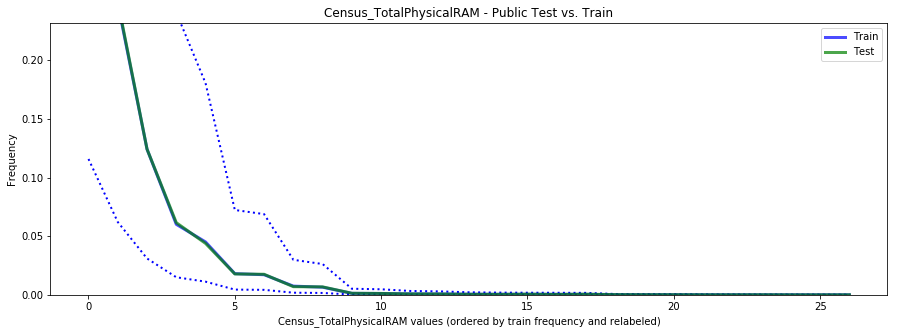

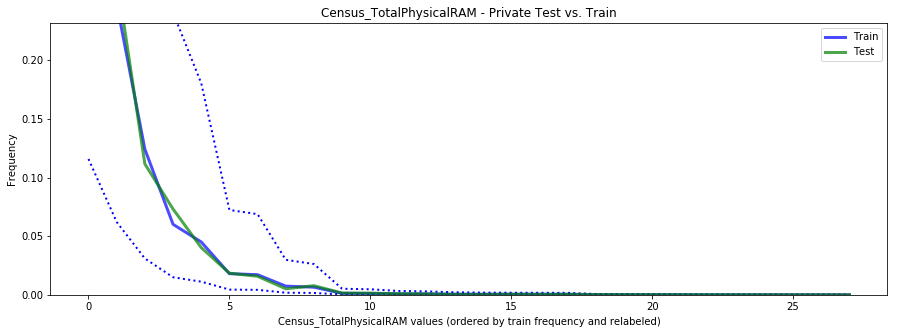

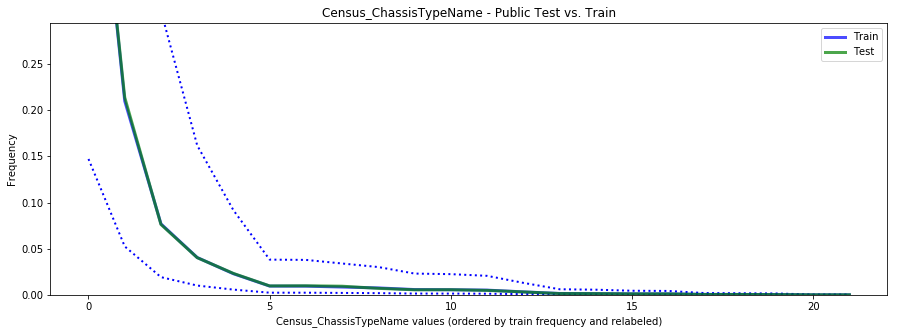

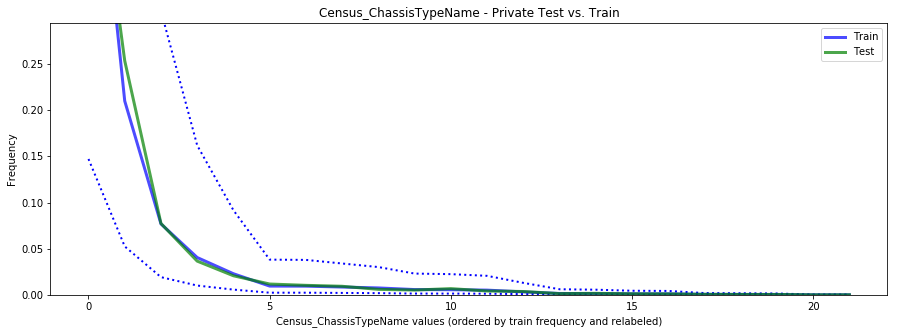

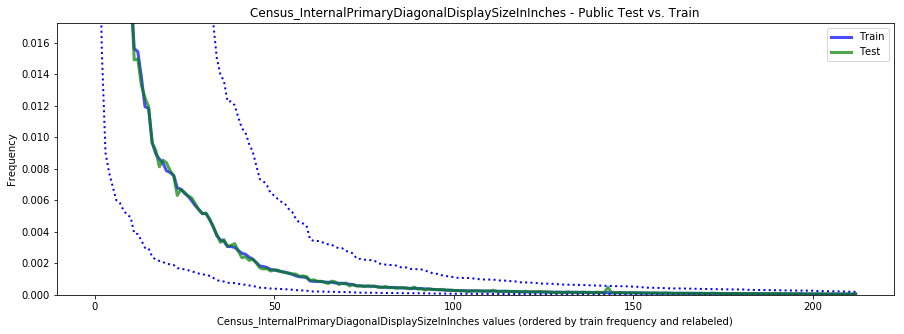

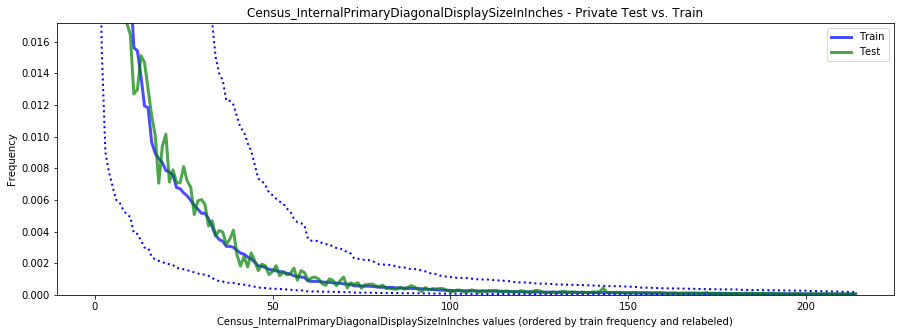

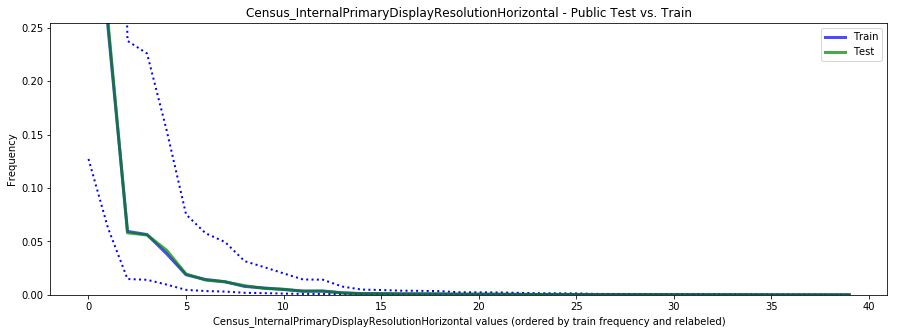

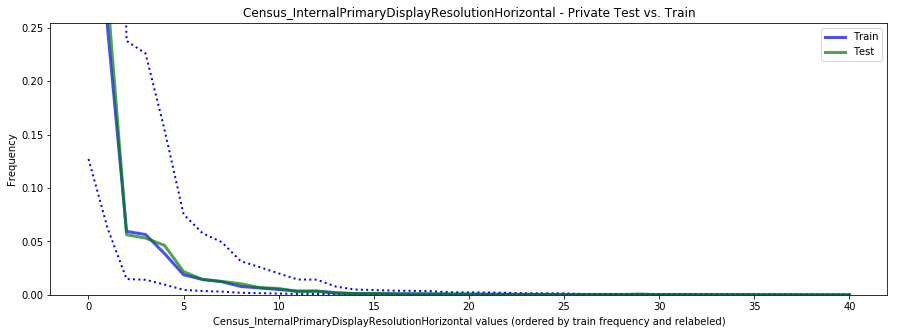

Private Test.csv Census_InternalPrimaryDisplayResolutionHorizontal has 1 values 4x MORE freq than Train.csv. ( 0.1 % of data)
['1800']


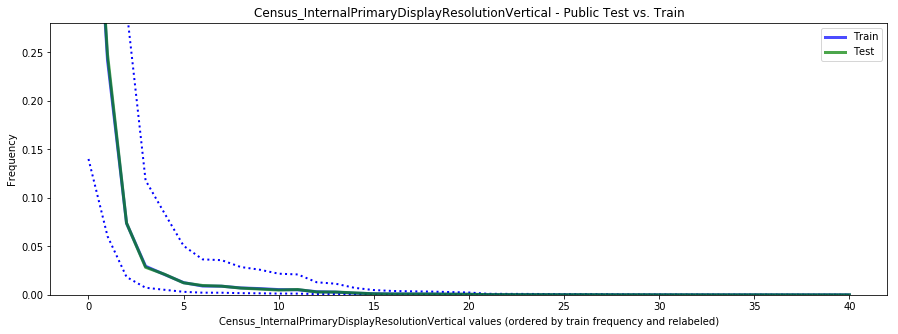

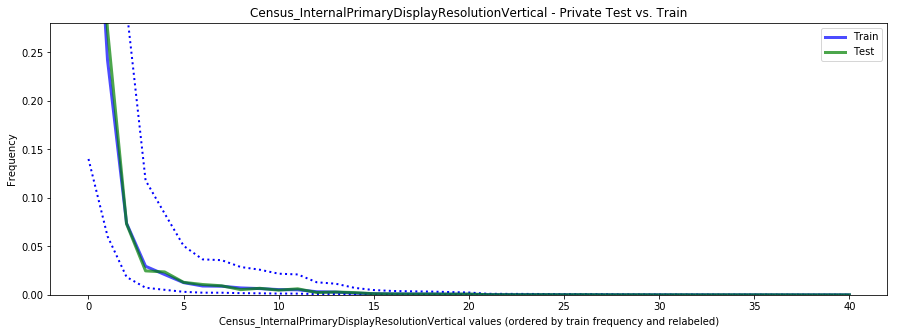

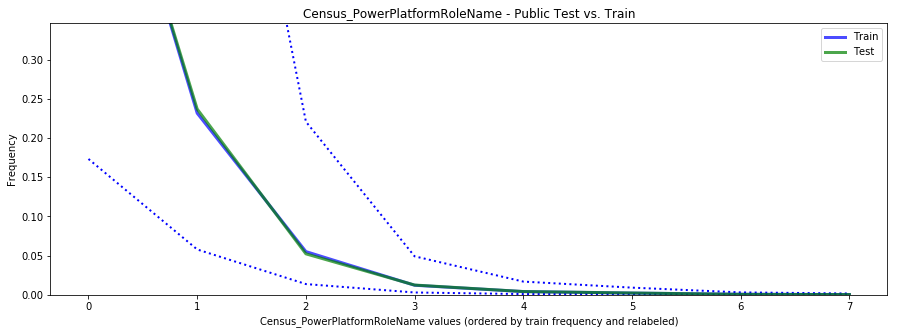

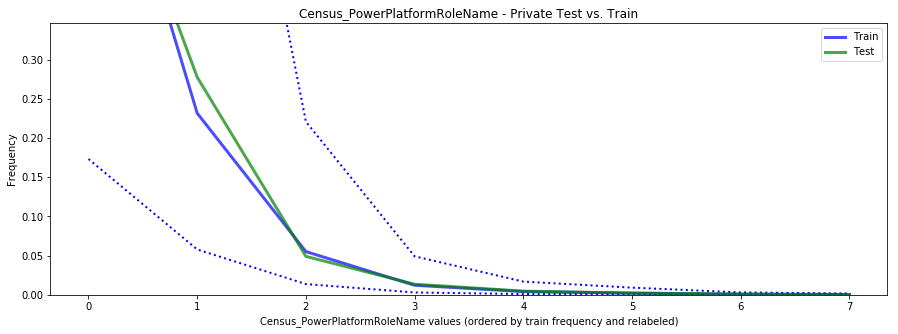

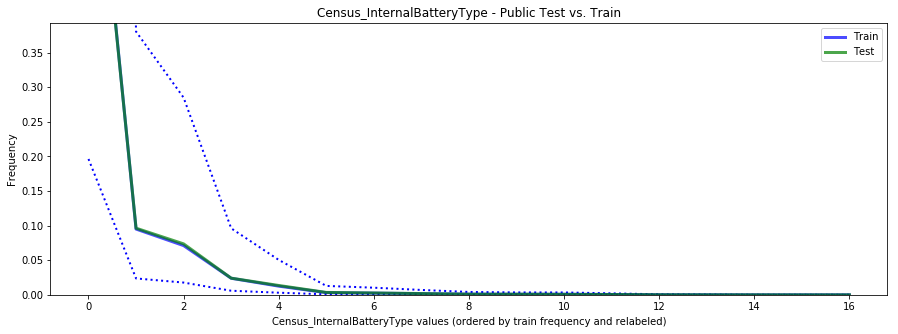

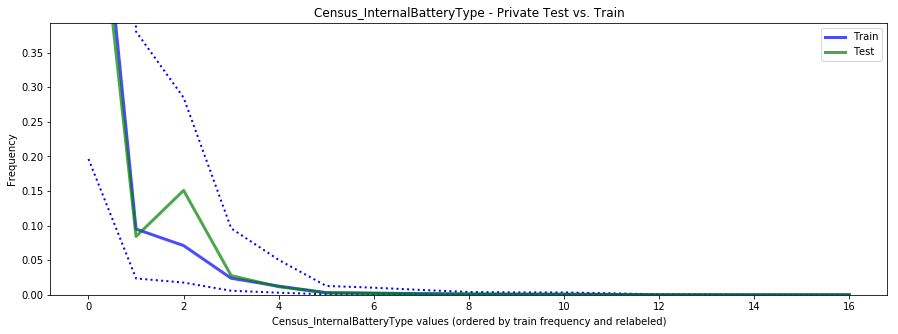

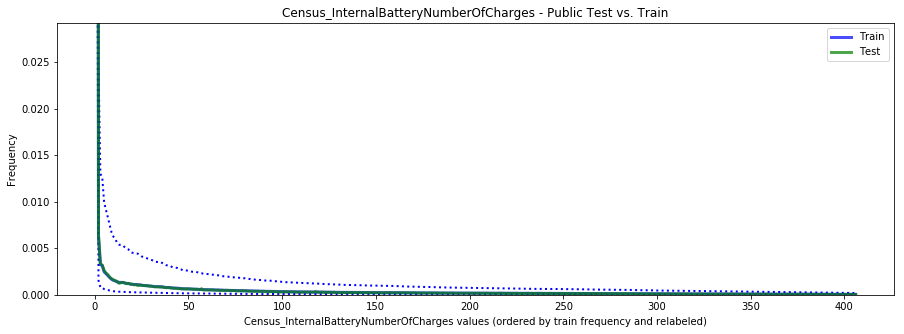

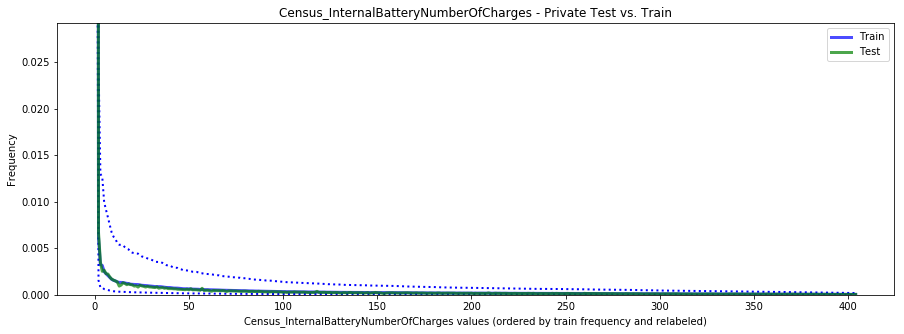

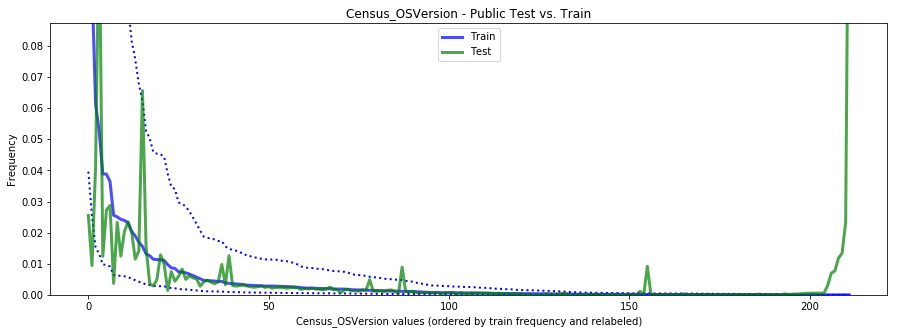

Public Test.csv Census_OSVersion has 24 values 4x MORE freq than Train.csv. ( 33.1 % of data)
  Top 10 by test freq: ['10.0.17134.345', '10.0.17134.286', '10.0.17134.320', '10.0.17763.55', '10.0.16299.726', '10.0.17763.1', '10.0.16299.666', '10.0.15063.1387', '10.0.17134.376', '10.0.17134.407']
Public Test.csv Census_OSVersion has 17 values 4x LESS freq than Train.csv. ( 4.4 % of data)
  Top 10 by test freq: ['10.0.17134.228', '10.0.17134.165', '10.0.17134.191', '10.0.15063.1206', '10.0.17134.167', '10.0.15063.1235', '10.0.15063.1209', '10.0.10240.17946', '10.0.14393.2363', '10.0.17692.1004']


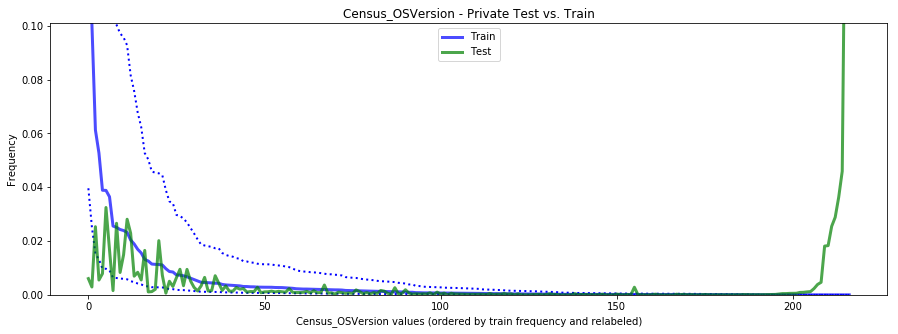

Private Test.csv Census_OSVersion has 26 values 4x MORE freq than Train.csv. ( 57.3 % of data)
  Top 10 by test freq: ['10.0.17134.407', '10.0.17134.345', '10.0.17134.376', '10.0.17763.134', '10.0.15063.1387', '10.0.16299.726', '10.0.17763.55', '10.0.16299.785', '10.0.15063.1418', '10.0.17763.107']
Private Test.csv Census_OSVersion has 30 values 4x LESS freq than Train.csv. ( 3.0 % of data)
  Top 10 by test freq: ['10.0.16299.547', '10.0.17134.228', '10.0.17134.285', '10.0.17134.165', '10.0.15063.1266', '10.0.17134.191', '10.0.15063.1206', '10.0.17134.254', '10.0.17134.167', '10.0.16299.579']


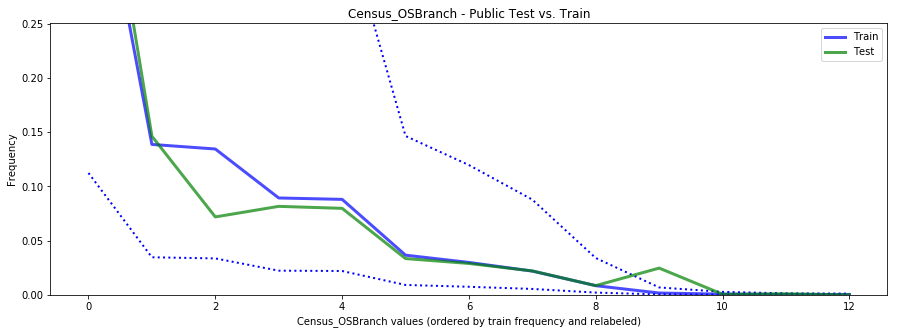

Public Test.csv Census_OSBranch has 1 values 4x MORE freq than Train.csv. ( 2.5 % of data)
['rs5_release']
Public Test.csv Census_OSBranch has 1 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['rs_prerelease_flt']


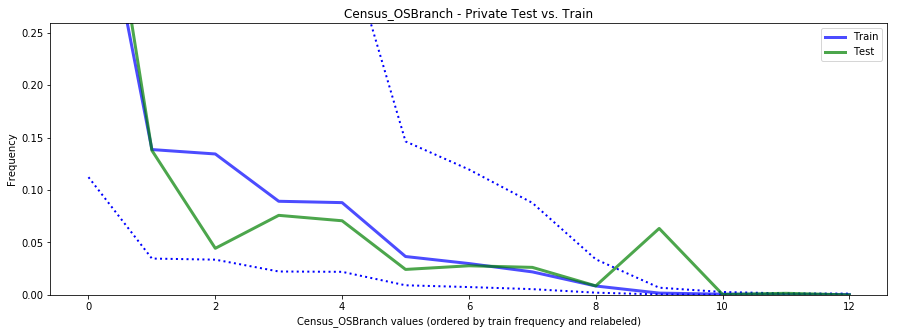

Private Test.csv Census_OSBranch has 2 values 4x MORE freq than Train.csv. ( 6.5 % of data)
['rs5_release', 'rs_prerelease']
Private Test.csv Census_OSBranch has 1 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['rs_prerelease_flt']


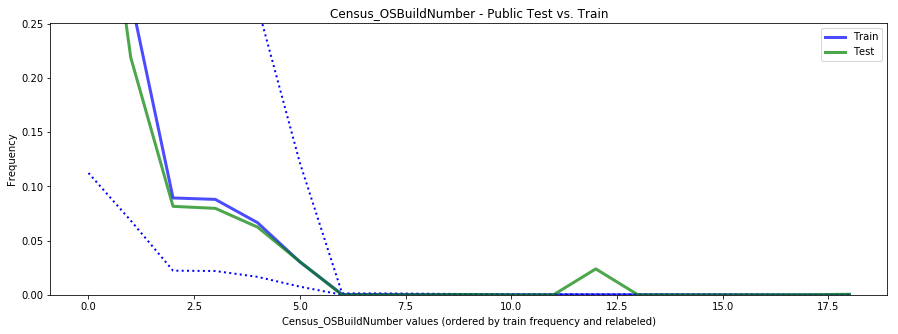

Public Test.csv Census_OSBuildNumber has 3 values 4x MORE freq than Train.csv. ( 2.5 % of data)
['17763', '18252', '18262']
Public Test.csv Census_OSBuildNumber has 5 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['17692', '17738', '17746', '17741', '17735']


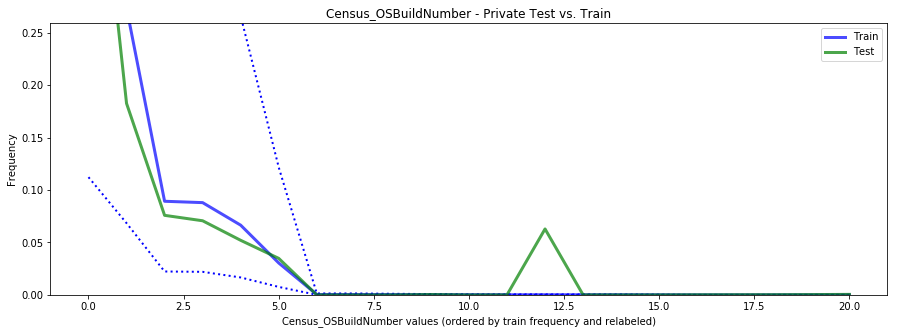

Private Test.csv Census_OSBuildNumber has 6 values 4x MORE freq than Train.csv. ( 6.4 % of data)
['17763', '18282', '18272', '18277', '18267', '18262']
Private Test.csv Census_OSBuildNumber has 7 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['17744', '17751', '17754', '17692', '17738', '17746', '17735']


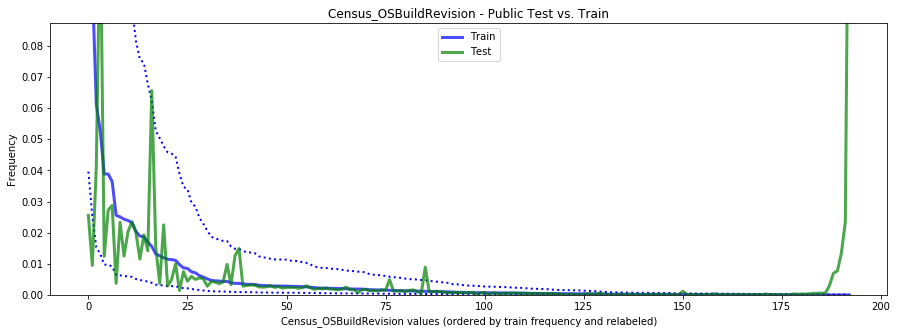

Public Test.csv Census_OSBuildRevision has 20 values 4x MORE freq than Train.csv. ( 32.4 % of data)
  Top 10 by test freq: ['345', '286', '320', '726', '55', '666', '1387', '376', '407', '1356']
Public Test.csv Census_OSBuildRevision has 13 values 4x LESS freq than Train.csv. ( 4.3 % of data)
  Top 10 by test freq: ['228', '165', '191', '1206', '167', '1235', '1209', '1004', '17946', '2363']


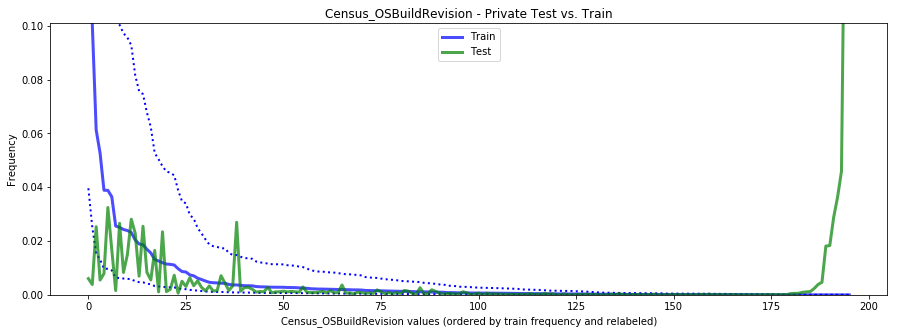

Private Test.csv Census_OSBuildRevision has 18 values 4x MORE freq than Train.csv. ( 56.9 % of data)
  Top 10 by test freq: ['407', '345', '376', '134', '1387', '726', '55', '785', '1418', '107']
Private Test.csv Census_OSBuildRevision has 25 values 4x LESS freq than Train.csv. ( 3.1 % of data)
  Top 10 by test freq: ['547', '228', '285', '165', '1266', '191', '1206', '254', '167', '579']


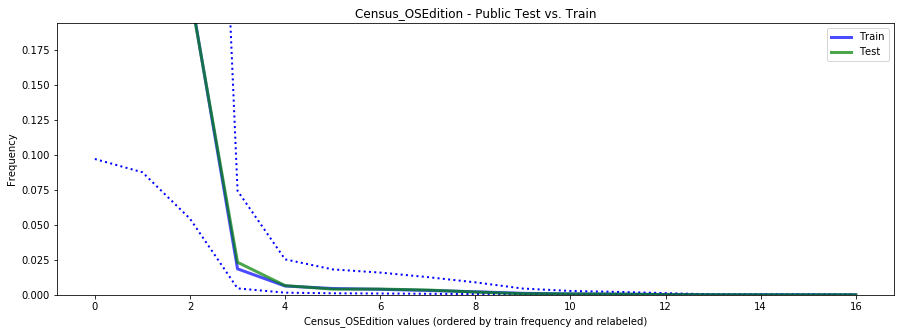

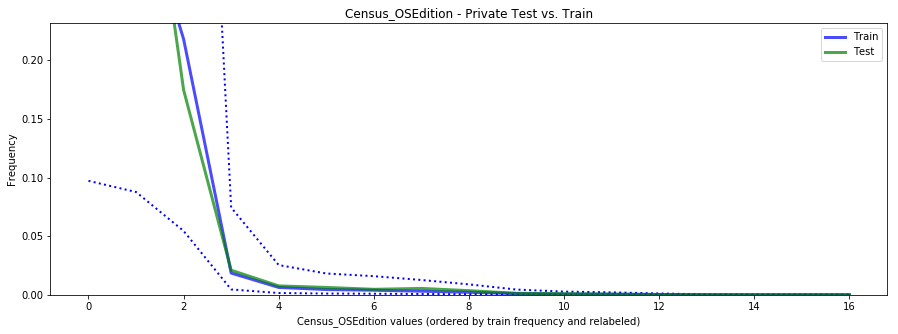

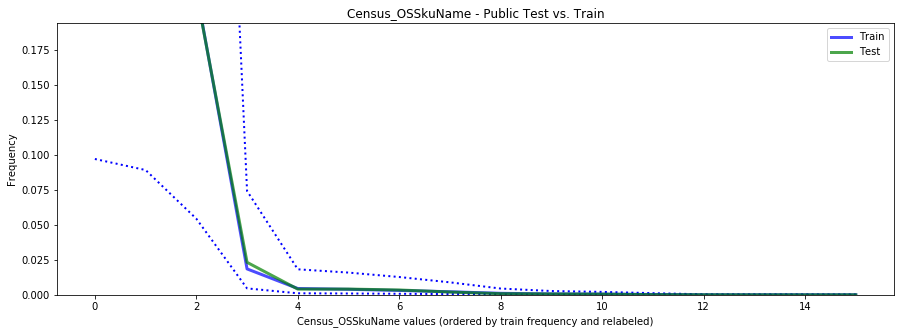

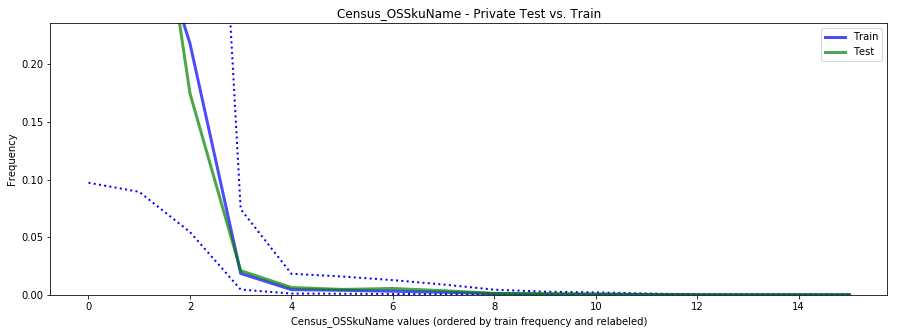

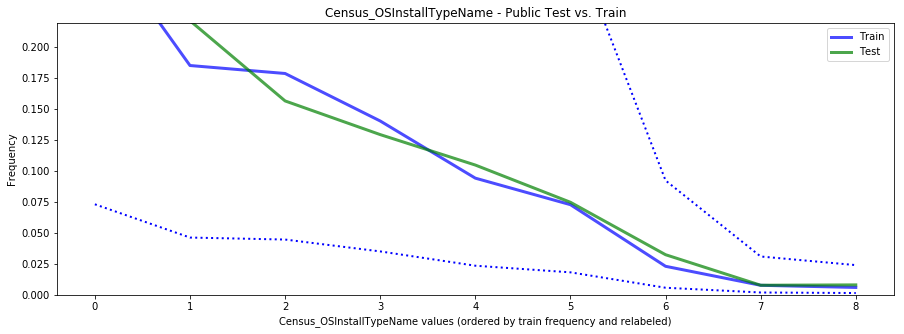

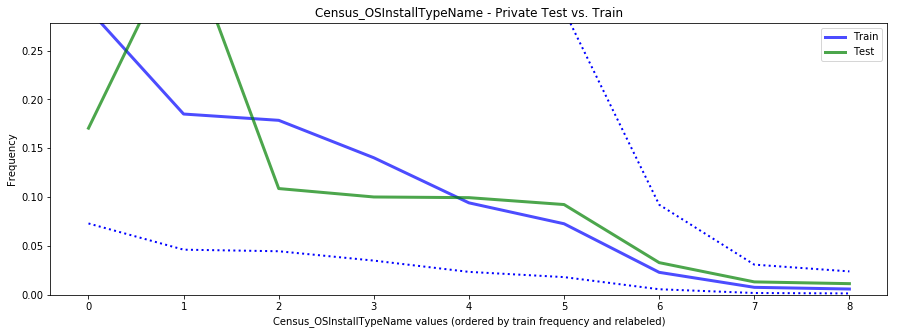

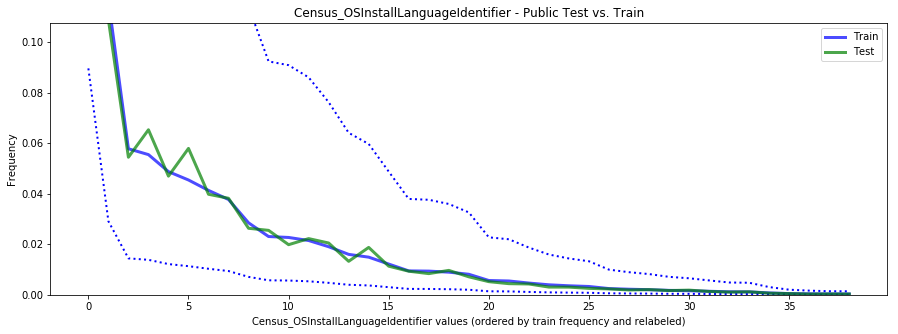

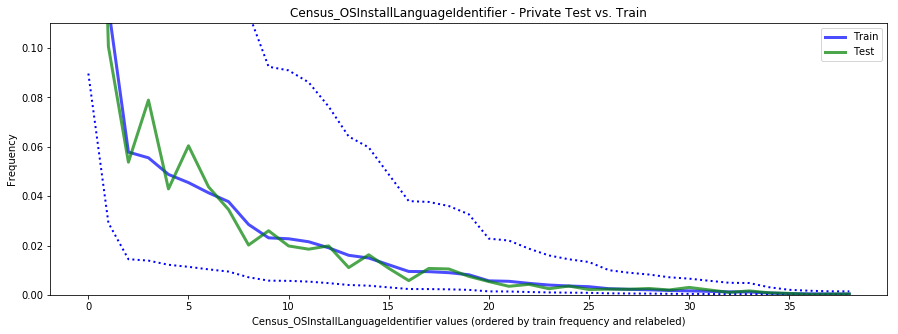

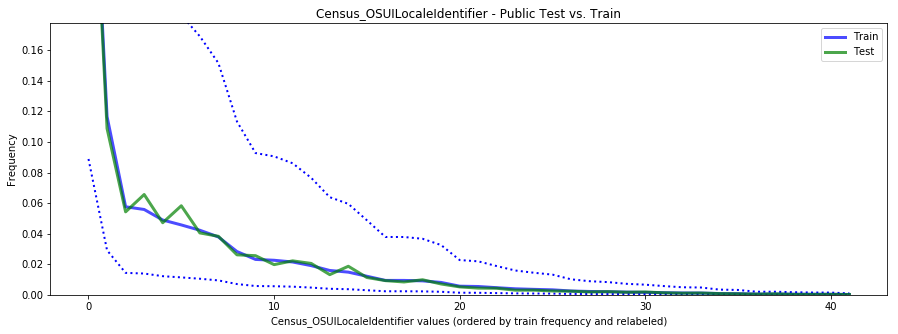

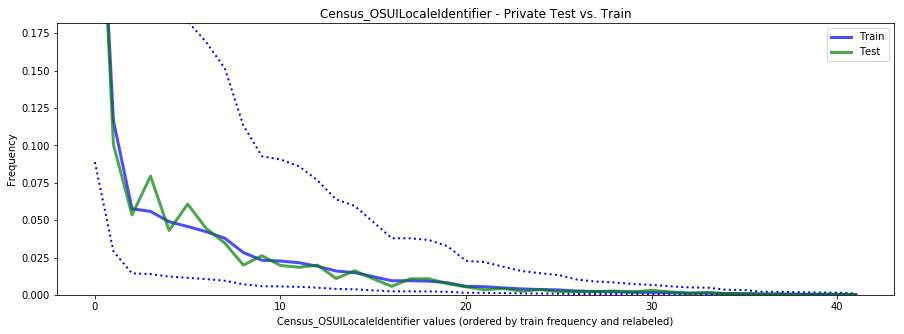

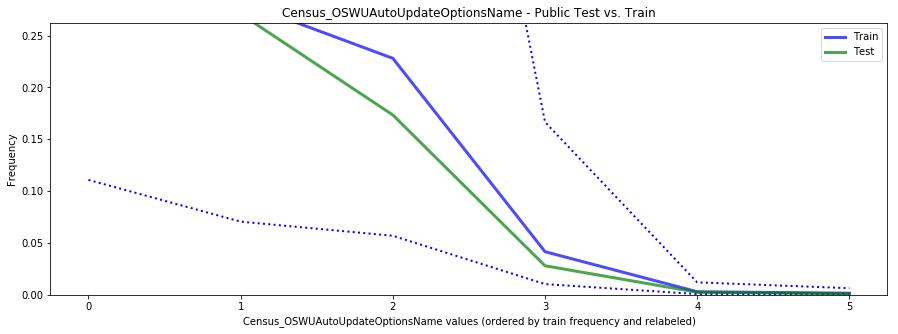

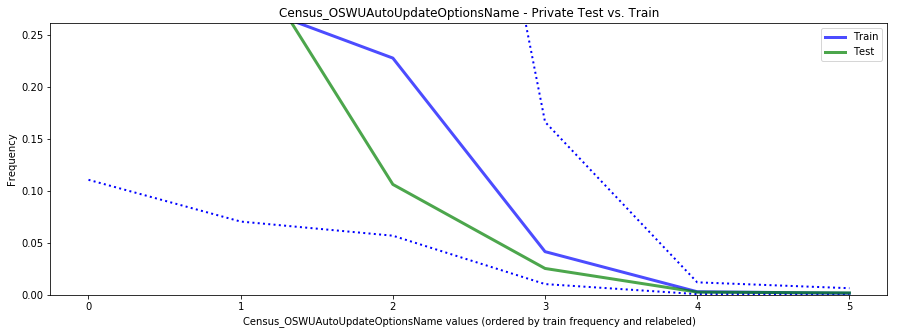

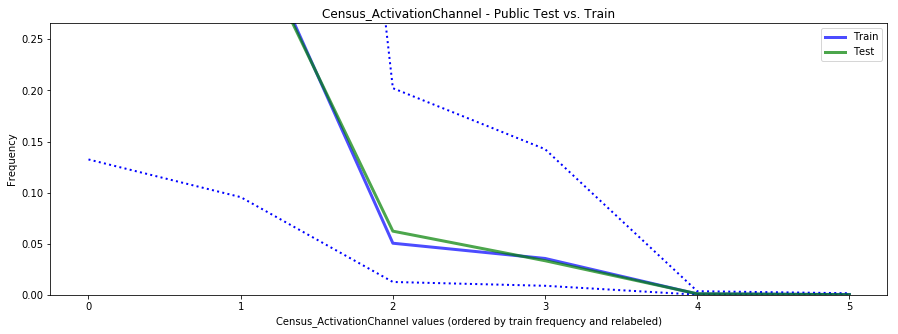

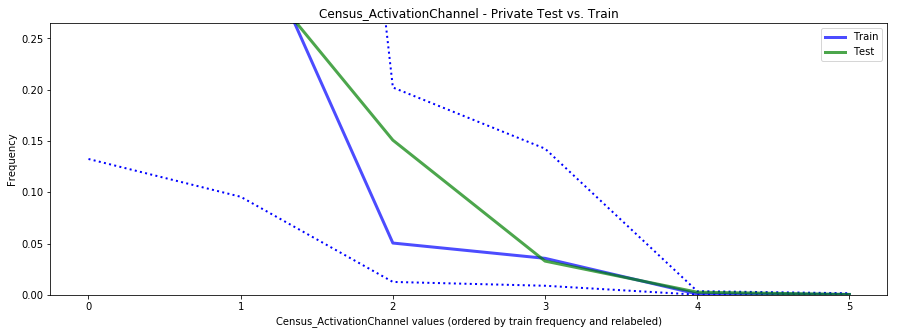

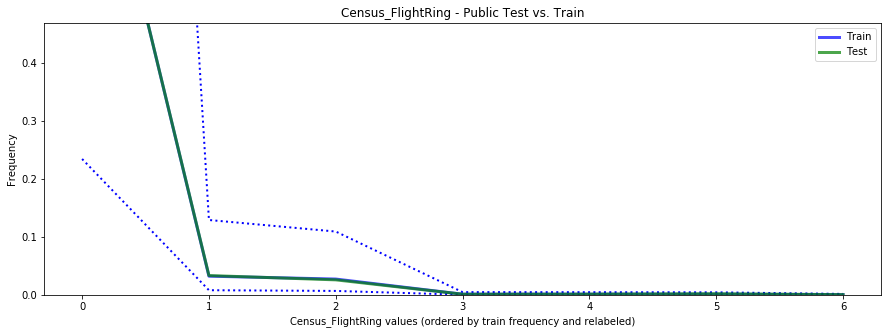

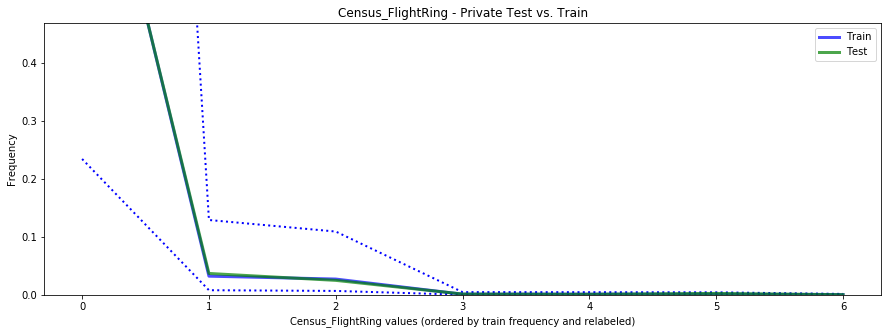

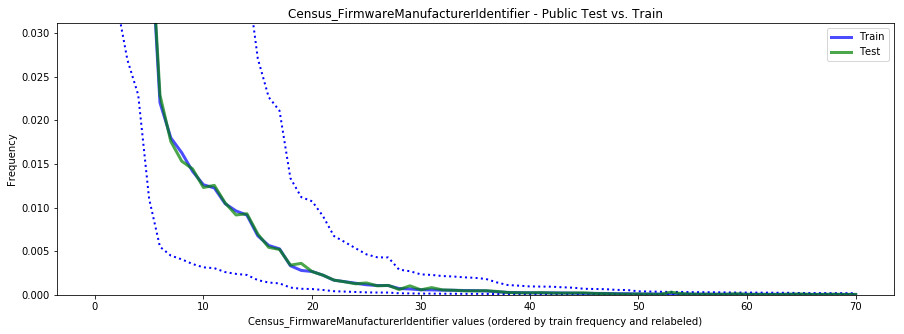

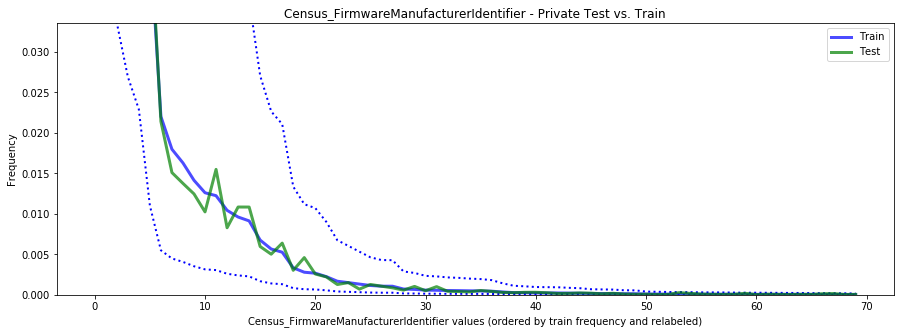

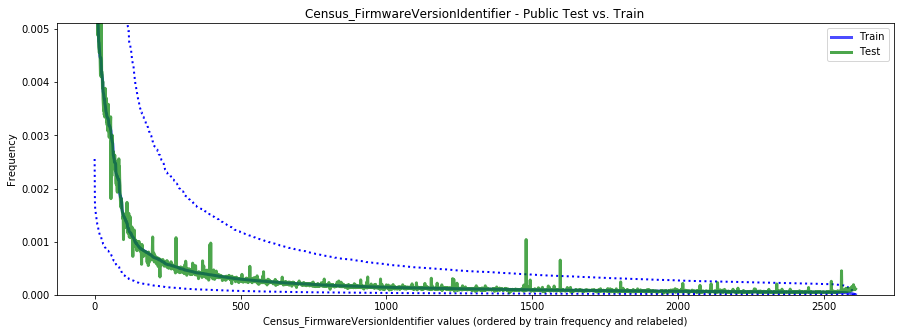

Public Test.csv Census_FirmwareVersionIdentifier has 20 values 4x MORE freq than Train.csv. ( 0.4 % of data)
  Top 10 by test freq: ['7763', '10761', '12307', '56012', '8246', '69278', '11917', '15902', '7138', '31635']


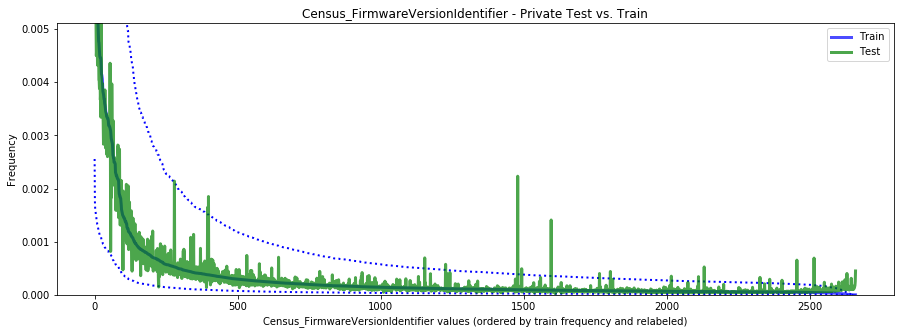

Private Test.csv Census_FirmwareVersionIdentifier has 80 values 4x MORE freq than Train.csv. ( 2.5 % of data)
  Top 10 by test freq: ['7763', '9358', '9783', '9373', '10761', '15824', '12307', '56012', '17464', '18445']
Private Test.csv Census_FirmwareVersionIdentifier has 1 values 4x LESS freq than Train.csv. ( 0.0 % of data)
['18669']


In [17]:
cols2 = {'AVProductStatesIdentifier':0.01, 'CountryIdentifier':0.4, 'LocaleEnglishNameIdentifier':0.3, 'SmartScreen':0.4,
         'Census_OEMNameIdentifier':0.1,'Census_TotalPhysicalRAM':0.5,'Census_InternalPrimaryDiagonalDisplaySizeInInches':0.05,
        'Census_OSInstallTypeName':0.75,'Census_OSInstallLanguageIdentifier':0.3,'Census_FirmwareManufacturerIdentifier':0.1,
        'EngineVersion':1.0, 'AppVersion':0.7, 'OsBuildLab':0.2, 'Census_OEMModelIdentifier':0.15,
        'Census_InternalBatteryNumberOfCharges':0.05}

df_train = pd.read_csv('../input/microsoft-malware-prediction/train.csv',dtype='category',usecols=load)
df_test = pd.read_csv('../input/microsoft-malware-prediction/test.csv',dtype='category',usecols=load)
df_test['DateAS'] = df_test['AvSigVersion'].map(datedictAS)
df_testA = df_test[ df_test['DateAS']<datetime(2018,10,25) ]
df_testB = df_test[ df_test['DateAS']>datetime(2018,10,25) ]

for x in df_train.columns[:-2]:
    s = 0.5
    if x in cols2: s = cols2[x] 
    comparePlot(df_train,df_testA,x,scale=s, title='Public Test vs. Train', prefix='Public ')
    comparePlot(df_train,df_testB,x,scale=s, title='Private Test vs. Train', prefix='Private ')